In [1]:
import pandas as pd
import datetime
import json
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import optimizers
from matplotlib.image import imread
from keras.preprocessing import image
from sklearn.metrics import r2_score
import seaborn as sns

Using TensorFlow backend.


### Pulling stock list from Virtus LifeSci Biotech ETF

In [0]:
stocks = ['ITCI', 'AXSM', 'CVM', 'KRTX', 'APLS', 'PRVB', 'CRTX', 'EPZM',
       'CRBP', 'CCXI', 'TGTX', 'IMGN', 'FATE', 'AKBA', 'DNLI', 'RIGL', 
       'PRNB', 'ARVN', 'ZYME', 'MRNA', 'CYTK', 'FTSV', 'ASND',
       'XBIT', 'ALEC', 'ORTX', 'ADVM', 'MGNX', 'AKRO', 'ESPR', 'BHVN',
       'YMAB', 'RGNX', 'MYOK', 'TPTX', 'ATNX', 'BLUE', 'AGEN', 'AVRO',
       'DCPH', 'CTMX', 'SRNE', 'ARDX', 'BCRX', 'RETA', 'KOD', 'DTIL',
       'RARX', 'AUTL', 'GTHX', 'CARA', 'KDMN', 'XNCR', 'ACHN', 'ARNA',
       'RCKT', 'TBIO', 'VYGR', 'SGMO', 'ODT', 'ANAB', 'ATRA', 'CNST',
       'GERN', 'BPMC', 'ALLO', 'BBIO', 'FGEN', 'PGNX', 'MGTX', 'NXTC',
       'IMMU', 'ZIOP', 'CRSP', 'IOVA', 'VKTX', 'EIDX', 'MYOV', 'AMRS',
       'KRYS', 'KURA', 'MDGL', 'UBX', 'TCDA', 'QURE', 'MRTX', 'ASMB',
       'GLYC', 'RYTM', 'FIXX', 'DRNA', 'ARWR', 'ALLK', 'GOSS', 'WVE']

In [3]:
pdr.get_data_yahoo(stocks[0], start='2000-01-01').head()

High        Low  Open      Close  Volume  Adj Close
Date                                                            
2014-01-07  17.00  15.000000  16.0  15.000000   59800  15.000000
2014-01-08  18.00  16.000000  17.5  17.000000   51100  17.000000
2014-01-09  17.75  17.100000  17.5  17.500000  159900  17.500000
2014-01-10  20.00  17.500000  17.5  18.000000  157100  18.000000
2014-01-13  18.50  18.200001  18.4  18.200001    5000  18.200001

#### Creating dictionary and JSON

In [0]:

dataframe_dict= {}
for stock in stocks: 

    df = pdr.get_data_yahoo(stock, start='2000-01-01')
    # Change inde to a date  string
    df['Date'] = df.index.strftime("%Y-%m-%d %H:%M:%S")
    
    dataframe_dict[stock] = df.to_dict('records')


In [0]:
data = dataframe_dict

### Creating a dictionary and JSON for Benchmark index and ETF

```python
benchmark_dict = {}
# SP500(broader market)
df = pdr.get_data_yahoo('SPY', start='2000-01-01')
df.index = df.index.strftime("%Y-%m-%d %H:%M:%S")
benchmark_dict['SPY'] = df.to_dict('index')

# Vanguard Health Care Index Fund (Healthcare Industry)
df = pdr.get_data_yahoo('VHT', start='2009-01-01')
df.index = df.index.strftime("%Y-%m-%d %H:%M:%S")
benchmark_dict['VHT'] = df.to_dict('index')

#SPDR S&P Pharmaceuticals ETF (Pharmaceutical Drug Industry)
df = pdr.get_data_yahoo('XPH', start='2009-01-01')
df.index = df.index.strftime("%Y-%m-%d %H:%M:%S")
benchmark_dict['XPH'] = df.to_dict('index')
```

### Creating the Target

In [0]:
#Next Day Max/Min Value (% Difference from Closing Price)¶
start = datetime.datetime.now()
period = [1, 2]
for stock in stocks:
    
    stock_dict_list = data[stock]
    num_days = len(stock_dict_list)
    for index, dict_ in enumerate(stock_dict_list):
        _open = dict_['Open']
        if index+period[1] >= num_days:
            _low = None
            _max = None
        else:
            _low = np.min([dict_['Low'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
            _max = np.max([dict_['High'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
        stock_dict_list[index]['Low_1'] = _low
        stock_dict_list[index]['Max_1'] = _max
    data[stock] = stock_dict_list

# 3 Day Max/Min Value (% Difference from Closing Price)
# The range is from the 2nd day to the 3rd after the input day
start = datetime.datetime.now()
period = [2, 4]
for stock in stocks:
    
    stock_dict_list = data[stock]
    num_days = len(stock_dict_list)
    for index, dict_ in enumerate(stock_dict_list):
        _open = dict_['Open']
        if index+period[1] >= num_days:
            _low = None
            _max = None
        else:
            _low = np.min([dict_['Low'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
            _max = np.max([dict_['High'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
        stock_dict_list[index]['Low_3'] = _low
        stock_dict_list[index]['Max_3'] = _max
    data[stock] = stock_dict_list

# 10 Day Max/Min Value (% Difference from Closing Price)
# The range is from the 4th day to the 10th after the input day

start = datetime.datetime.now()
period = [4, 11]
for stock in stocks:
    
    stock_dict_list = data[stock]
    num_days = len(stock_dict_list)
    for index, dict_ in enumerate(stock_dict_list):
        _open = dict_['Open']
        if index+period[1] >= num_days:
            _low = None
            _max = None
        else:
            _low = np.min([dict_['Low'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
            _max = np.max([dict_['High'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
        stock_dict_list[index]['Low_10'] = _low
        stock_dict_list[index]['Max_10'] = _max
    data[stock] = stock_dict_list

# 30 Day Max/Min Value (% Difference from Closing Price)
# The range is from the 11th day to the 30th after the input day
start = datetime.datetime.now()
period = [11, 31]
for stock in stocks:
    
    stock_dict_list = data[stock]
    num_days = len(stock_dict_list)
    for index, dict_ in enumerate(stock_dict_list):
        _open = dict_['Open']
        if index+period[1] >= num_days:
            _low = None
            _max = None
        else:
            _low = np.min([dict_['Low'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
            _max = np.max([dict_['High'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
        stock_dict_list[index]['Low_30'] = _low
        stock_dict_list[index]['Max_30'] = _max
    data[stock] = stock_dict_list

#### Scaling Input

In [0]:
for stock in stocks:
  df = pd.DataFrame(data[stock])
  max_value = df[['High', 'Low', 'Open', 'Close', 'Adj Close']].max()
  df[['High', 'Low', 'Open', 'Close', 'Adj Close']] = df[['High', 'Low', 'Open', 'Close', 'Adj Close']]/max_value
  df['Volume'] = df['Volume']/ df['Volume'].max()
  df= df.dropna()
  data[stock] = df.to_dict('records')

#### Check scaling

In [8]:
data_in_list = []
for stock in stocks:
    stock_dict_list = data[stock]
    for index, dict_ in enumerate(stock_dict_list):
        dict_['Ticker'] = stock
        data_in_list.append(dict_)
df = pd.DataFrame(data_in_list) 
df.describe()

High            Low  ...         Low_30         Max_30
count  145564.000000  145564.000000  ...  145564.000000  145564.000000
mean        0.259568       0.262671  ...      -0.035546       0.392176
std         0.230338       0.231395  ...      17.383586      32.358070
min         0.000003       0.000003  ...      -0.999833      -0.951601
25%         0.073184       0.075036  ...      -0.235139       0.013825
50%         0.186549       0.190306  ...      -0.123070       0.130841
75%         0.384021       0.386618  ...      -0.020000       0.298995
max         1.000000       1.000000  ...    3998.999810    9998.999525

[8 rows x 14 columns]

#### Scaling High, Low, Open, Close and droping Adj Close

In [0]:
processed_data = {}

for stock in stocks:
  x = []
  target = []
  dict_ = {}
  for i in data[stock]:
    row =np.array([i['High'], i['Low'], i['Open'], i['Close'], i['Adj Close'], i['Volume']])
    x.append(row)
    row = np.array(i['Low_1'])
    target.append(row)
  length_ = (len(x)//25)*25
  dict_['Data'] = x[:length_]
  dict_['Target'] = target[:length_]
  processed_data[stock] = dict_

In [0]:
for stock in stocks:
  length_ = len(processed_data[stock]['Data'])
  length_test = len(processed_data[stock]['Data'])//8
  test_start = length_- 50
  test_end = length_test+ test_start
  processed_data[stock]['data_1'] = np.array(processed_data[stock]['Data'][:test_start])
  processed_data[stock]['data_1'] =   processed_data[stock]['data_1'].reshape(len(processed_data[stock]['data_1']), 1, 6)
  processed_data[stock]['data_test'] = np.array(processed_data[stock]['Data'][test_start:])
  processed_data[stock]['data_test'] = processed_data[stock]['data_test'].reshape(len(processed_data[stock]['data_test']),1,6)
  transfer_list = np.array(processed_data[stock]['Target'][:test_start])
  processed_data[stock]['target_1'] =transfer_list.reshape(len(transfer_list), 1)
  transfer_list = np.array(processed_data[stock]['Target'][test_start:])
  processed_data[stock]['target_test'] = transfer_list.reshape(len(transfer_list),1)

In [11]:
model = models.Sequential()
model.add(layers.GRU(50, return_sequences=True, batch_input_shape=(25, 1,6), stateful= True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(100, return_sequences=True, stateful= True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(100, return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = "linear"))
model.compile(loss='mse', optimizer='adam')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4900 samples, validate on 50 samples
Epoch 1/1000





4900/4900 [==============================] - 4s 905us/step - loss: 0.0038 - val_loss: 0.0020
Epoch 2/1000
4900/4900 [==============================] - 2s 396us/step - loss: 0.0037 - val_loss: 0.0020
Epoch 3/1000
4900/4900 [==============================] - 2s 390us/step - loss: 0.0036 - val_loss: 0.0026
Epoch 4/1000
4900/4900 [==============================] - 2s 426us/step - loss: 0.0036 - val_loss: 0.0020
Epoch 5/1000
4900/4900 [==============================] - 2s 397us/step - loss: 0.0033 - val_loss: 0.0015
Epoch 6/1000
4900/4900 [==============================] - 2s 458us/step - loss: 0.0029 - val_loss: 0.0012
Epoch 7/1000
4900/4900 [==============================] - 2s 427us/step - loss: 0.0027 - val_loss: 0.0012
Epoch 8/1000
4900/4900 [==============================] - 2s 385us/step - loss: 0.0026 - val_loss: 0.0011
Epoc

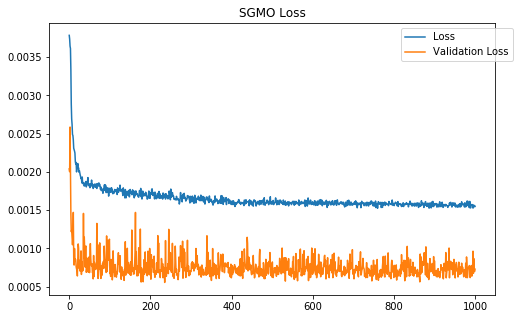

In [12]:
stock = 'SGMO'
(feature_train, label_train, feature_test, label_test) = (processed_data[stock]['data_1'],processed_data[stock]['target_1'], 
                                                            processed_data[stock]['data_test'], processed_data[stock]['target_test']) 
model.fit(feature_train, label_train, batch_size=25, epochs=1000, validation_data = (feature_test, label_test))
dict_ = model.history.history
plt.figure(figsize=(8,5))
plt.title(f"{stock} Loss")
plt.plot(dict_['loss'], label = 'Loss')
plt.plot(dict_['val_loss'], label= 'Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

SGMO 0.248780904424719 0.3553985162745422


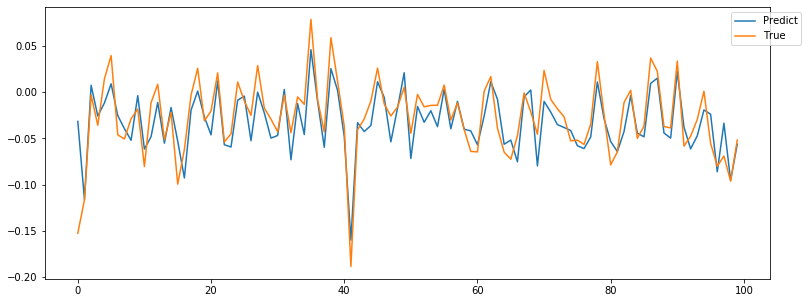

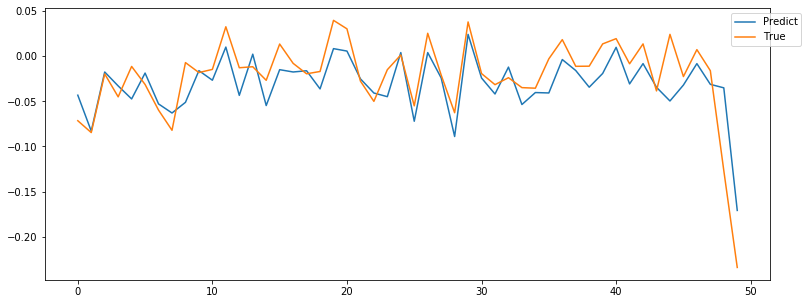

In [13]:
predict_train = model.predict(feature_train, batch_size=25)
predict_test = model.predict(feature_test, batch_size=25)
print(stock,r2_score(predict_test, label_test), r2_score(predict_train, label_train))
plt.figure(figsize=(13,5))
plt.plot(predict_train[-100:], label = 'Predict')
plt.plot(label_train[-100:], label= 'True')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

plt.figure(figsize=(13,5))
plt.plot(predict_test[-100:], label = 'Predict')
plt.plot(label_test[-100:], label= 'True')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

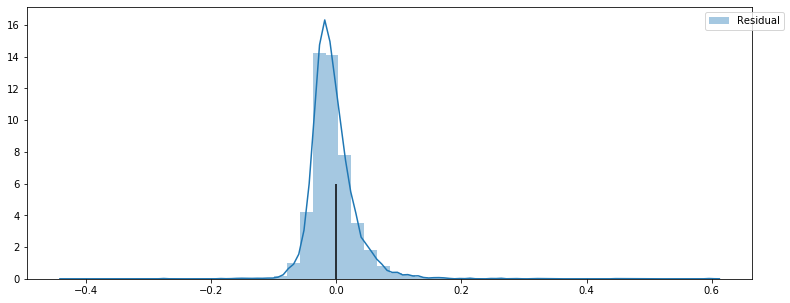

In [14]:
plt.figure(figsize=(13,5))
sns.distplot(predict_train- label_train, label = 'Residual')
plt.vlines(0,0,6)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

ITCI 0.2488542876810541 0.3552176626354555


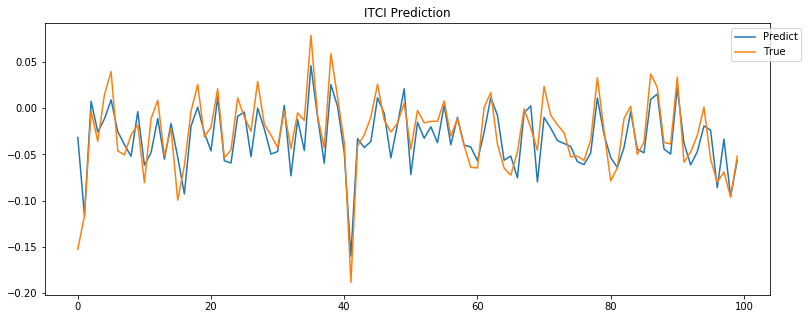

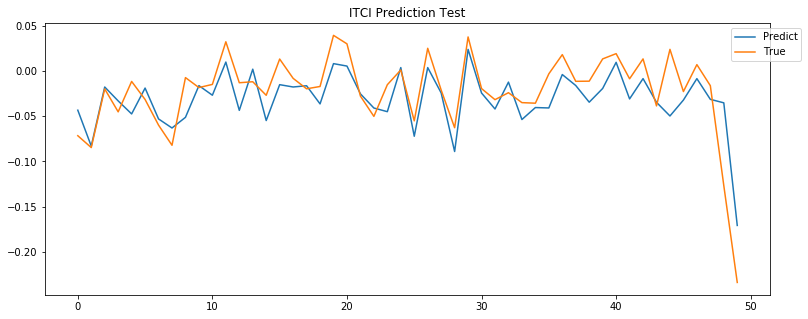

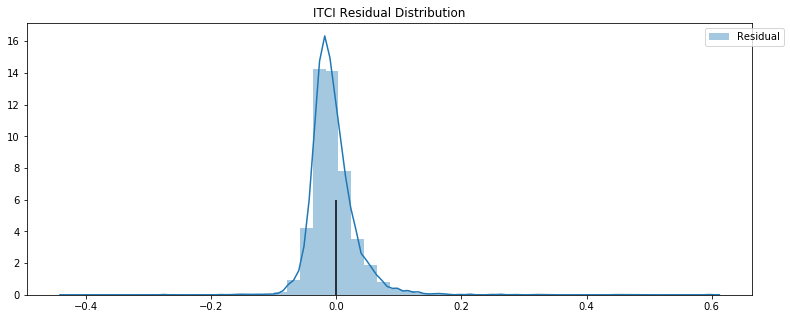

AXSM 0.2488912041083835 0.3552133411988603


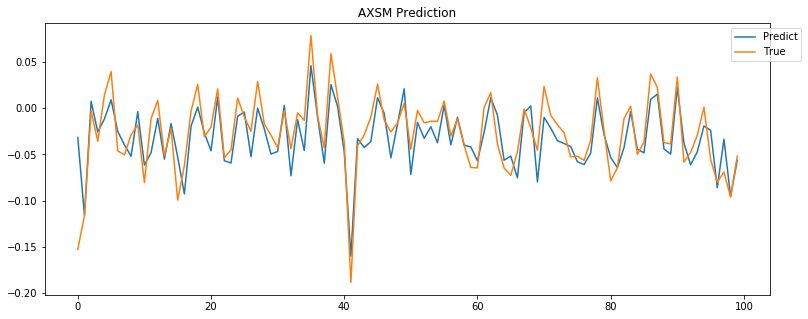

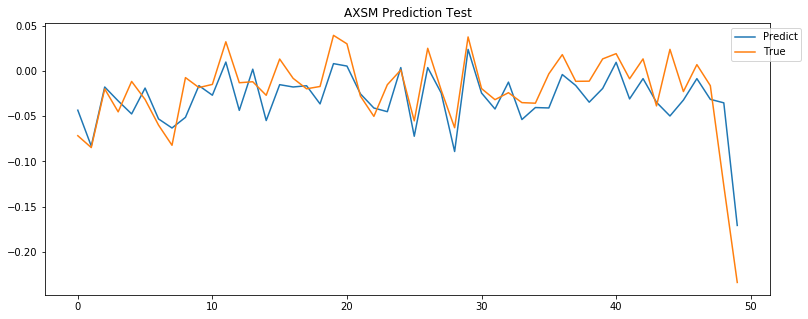

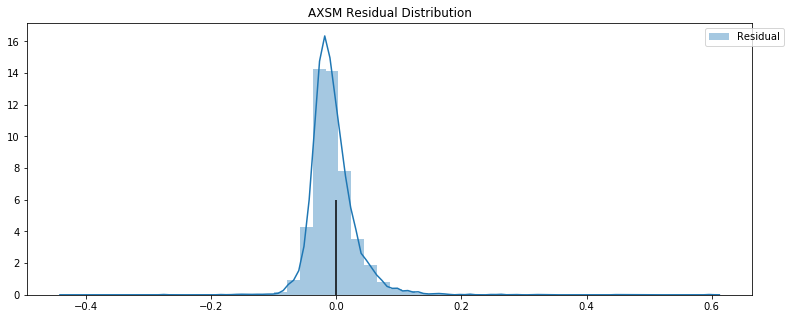

CVM 0.2489141404924312 0.35521409193525166


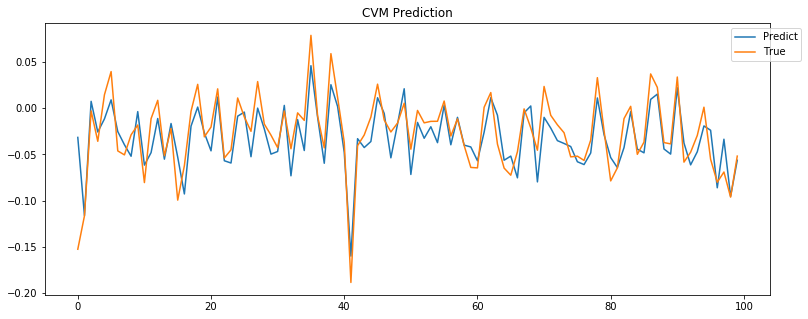

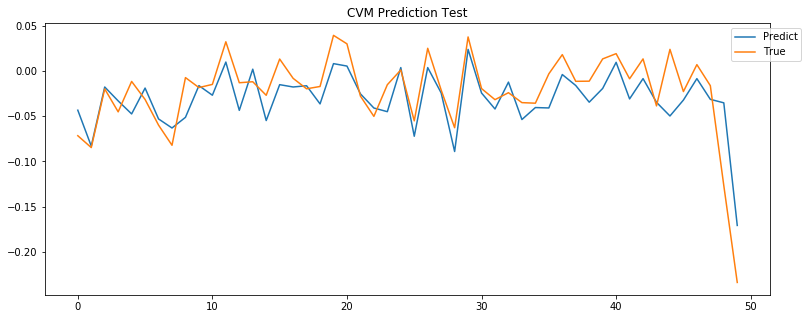

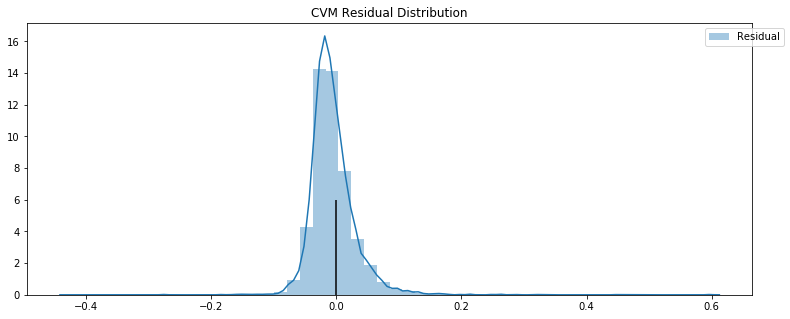

KRTX 0.24893027944540314 0.3552157038966328


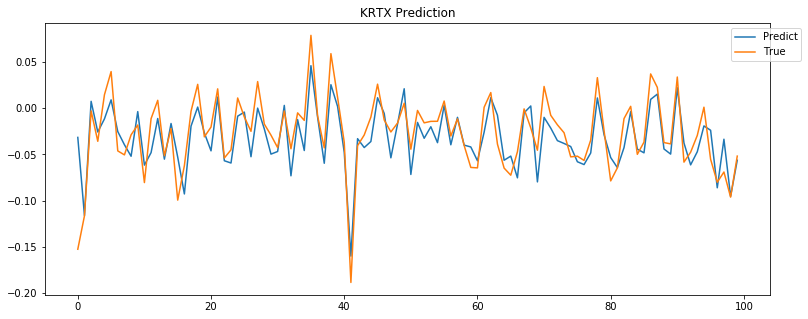

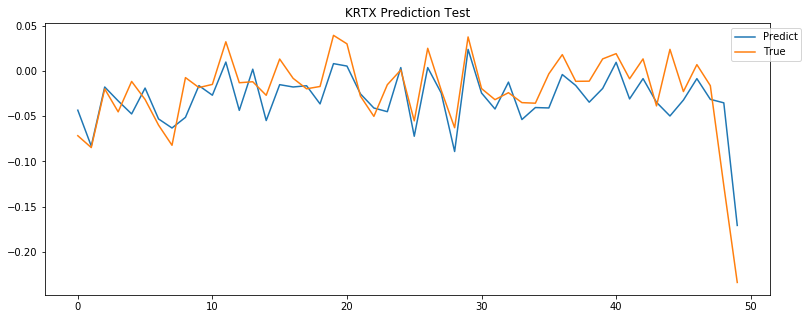

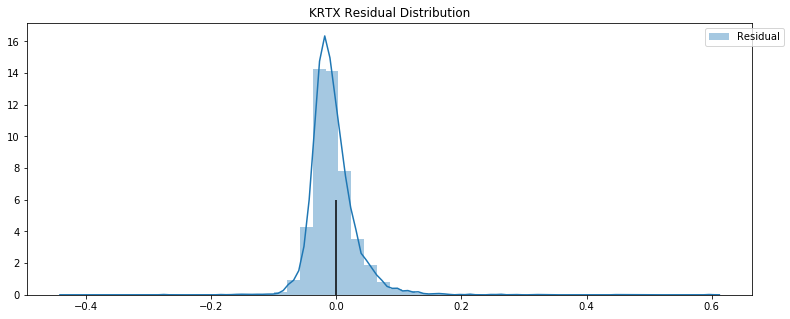

APLS 0.24894269489710763 0.35521710677111307


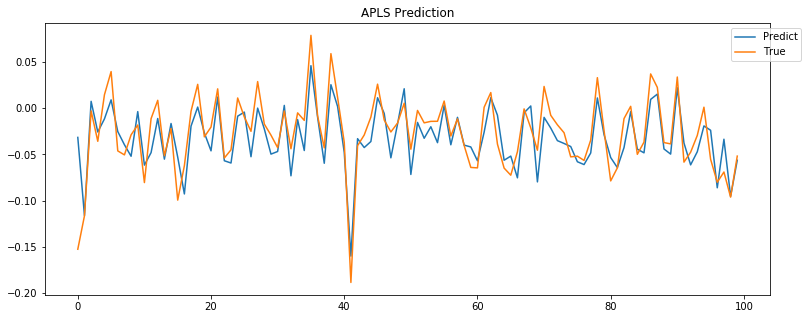

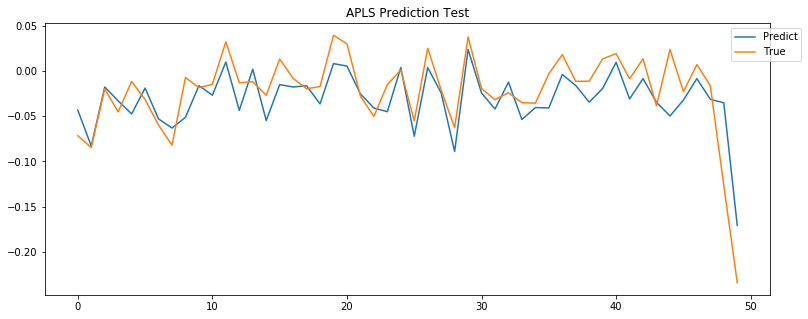

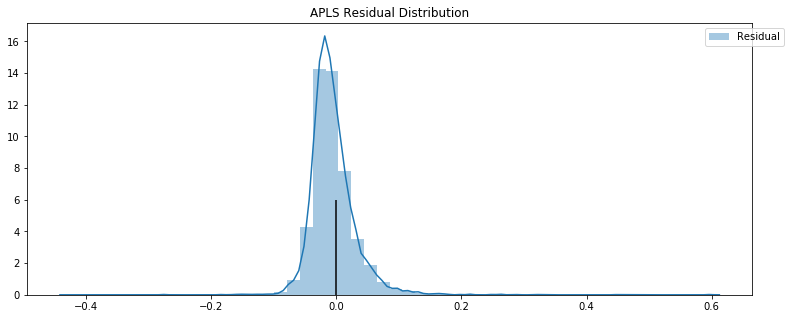

PRVB 0.2489528792893385 0.3552181181428231


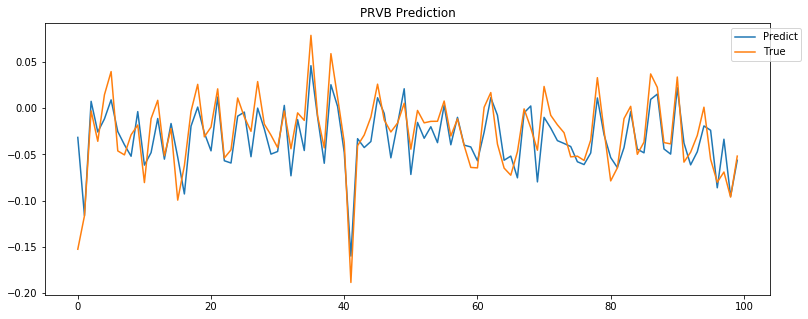

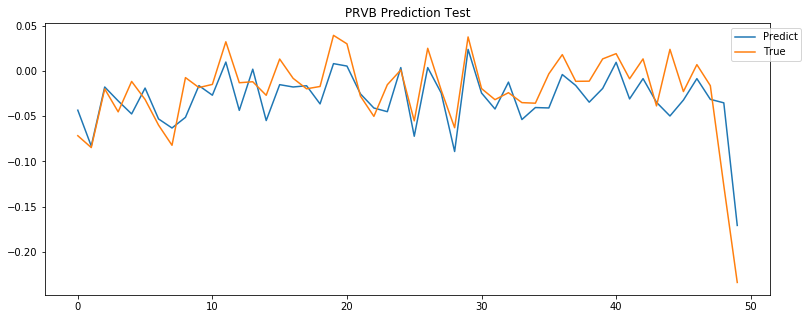

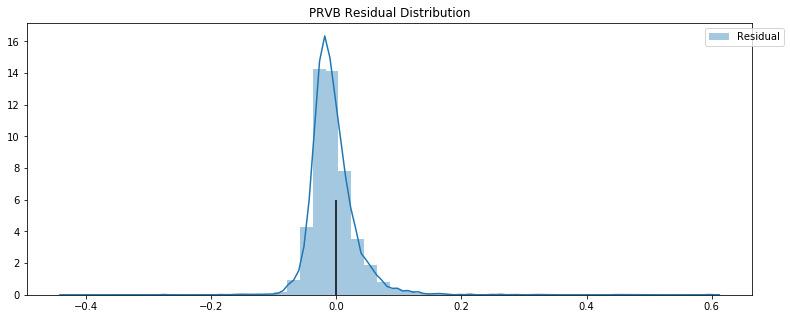

CRTX 0.2489612368969274 0.3552187940969076


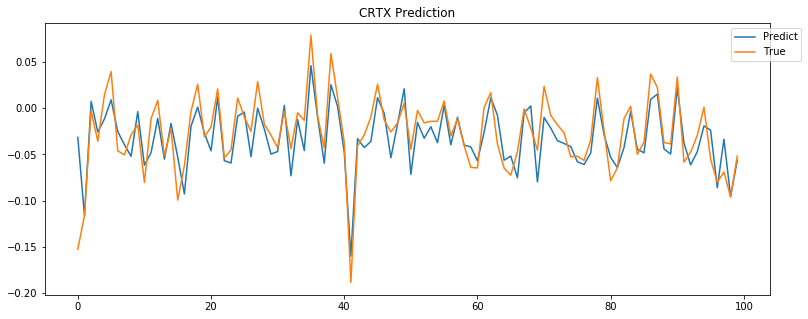

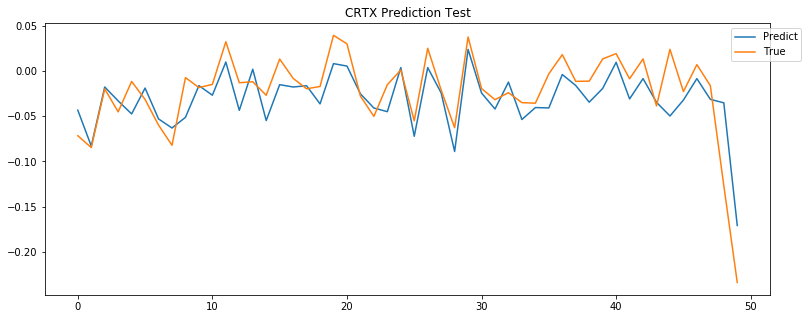

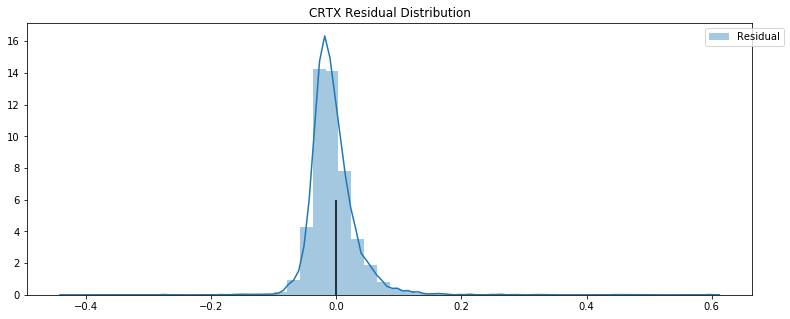

EPZM 0.24896853396896412 0.3552191744382026


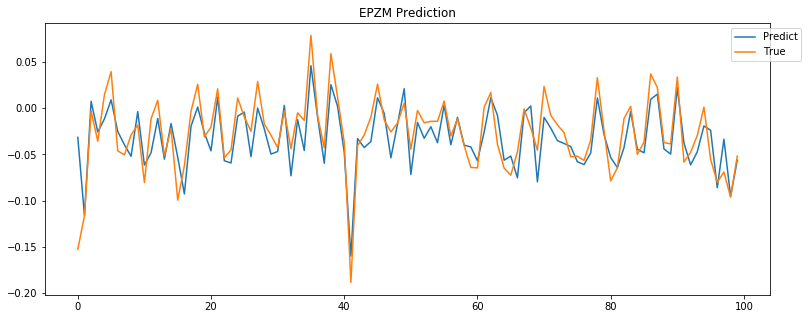

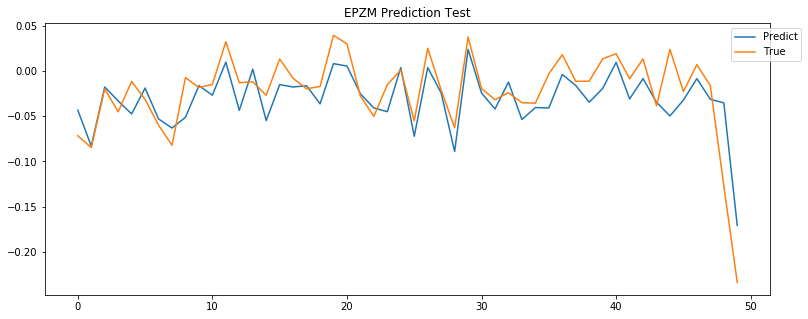

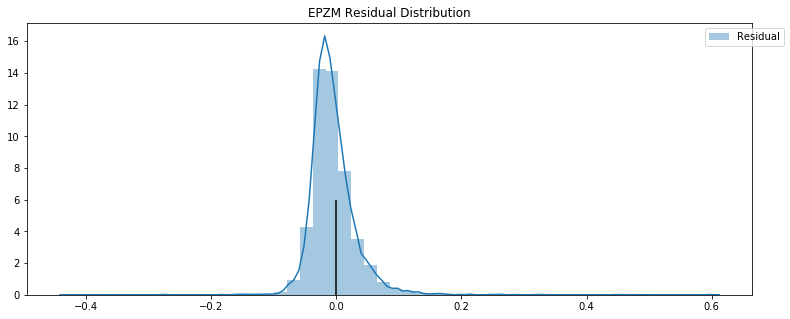

CRBP 0.24897490707667735 0.35521931719239586


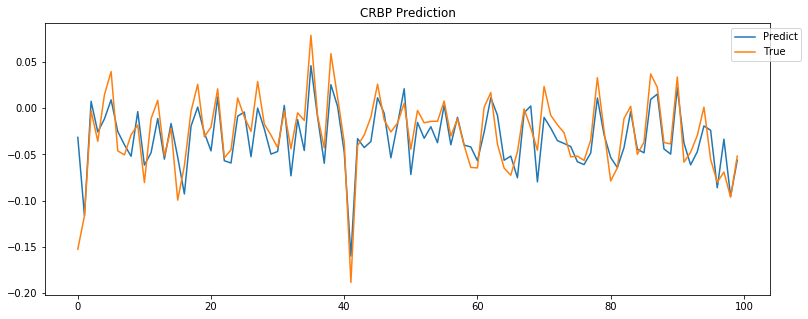

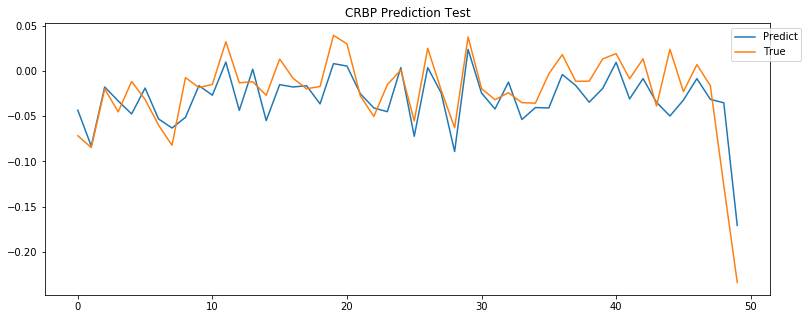

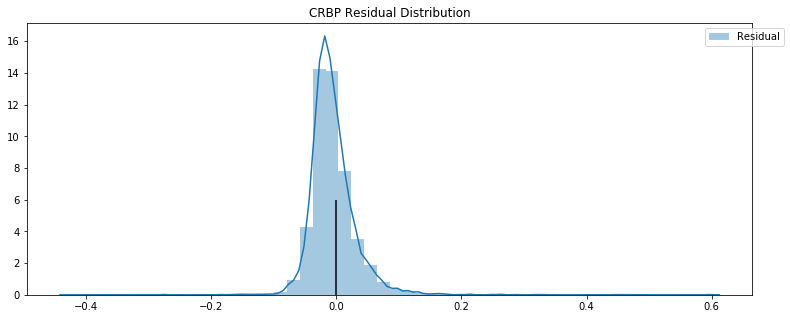

CCXI 0.24898063857306296 0.3552192832022484


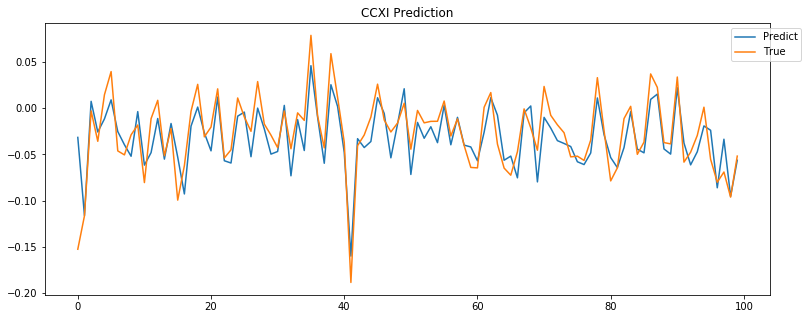

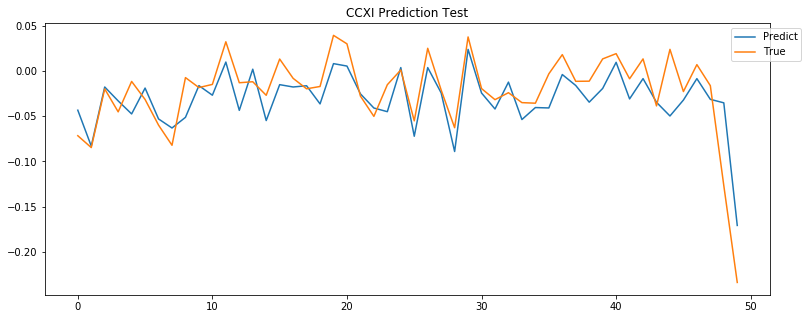

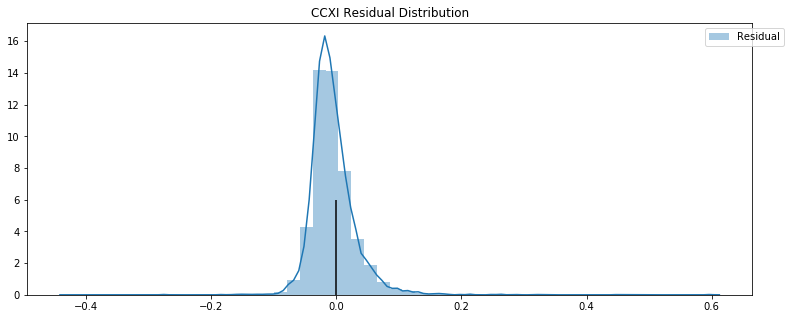

TGTX 0.24898568478761873 0.35521909389222084


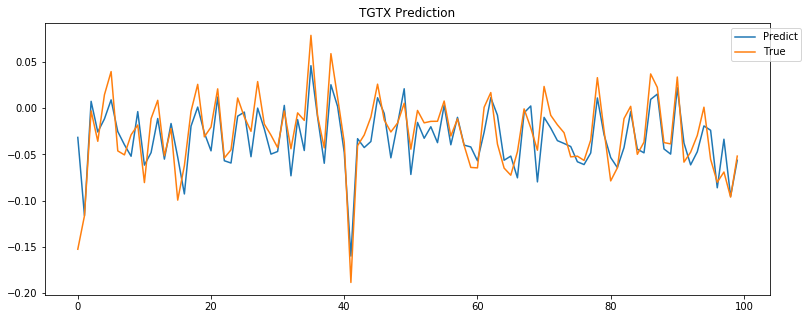

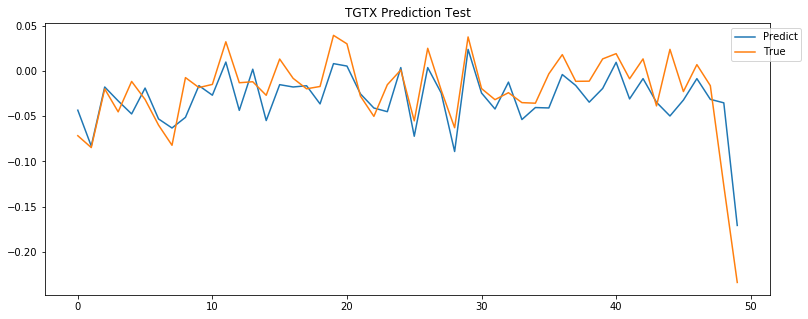

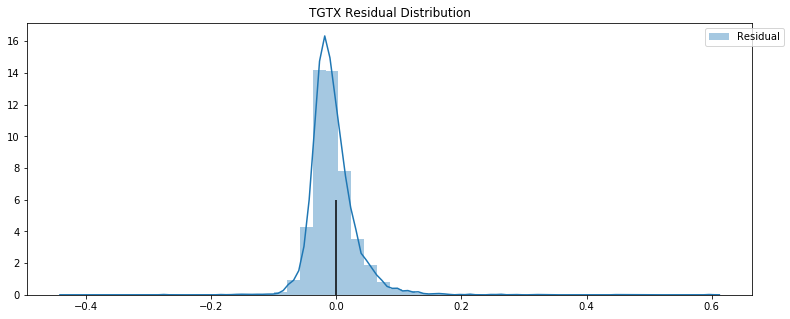

IMGN 0.24899037502011412 0.35521883382853126


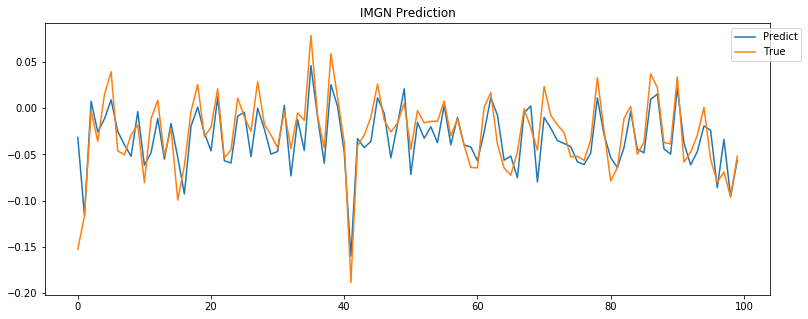

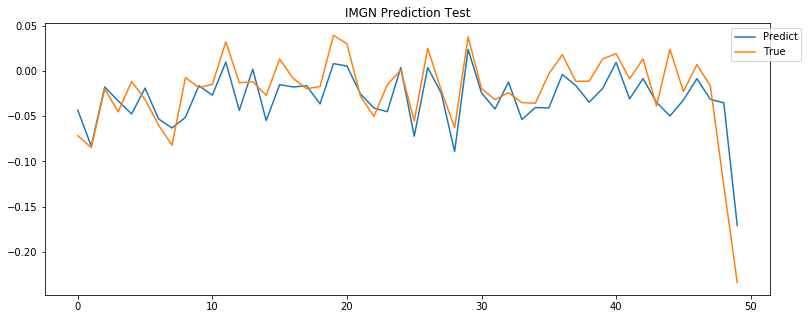

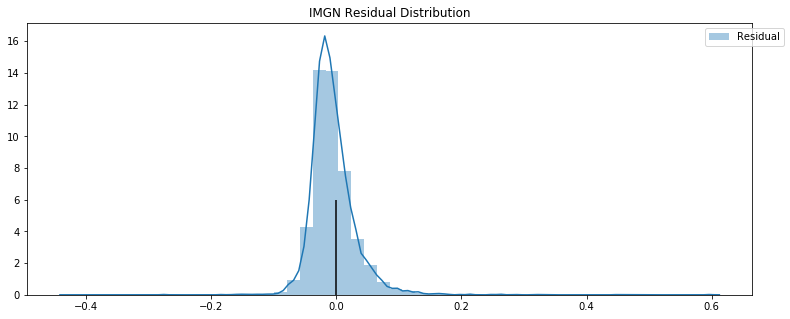

FATE 0.24899457258349889 0.3552185150447601


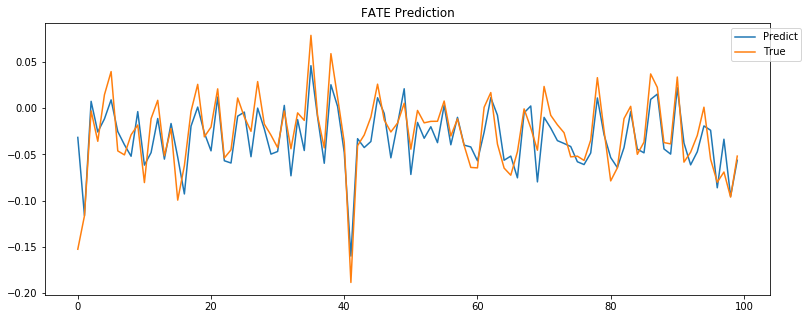

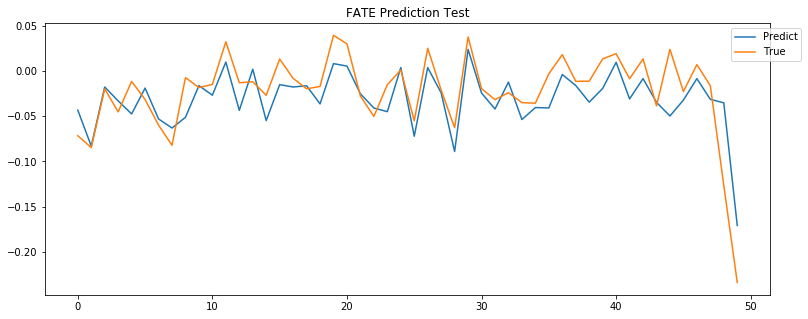

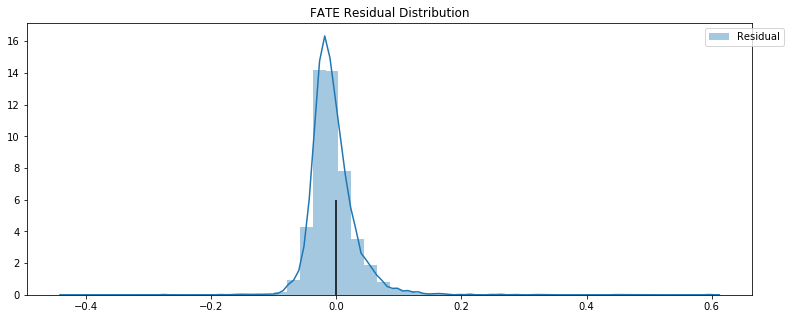

AKBA 0.24899841434538217 0.3552181187935567


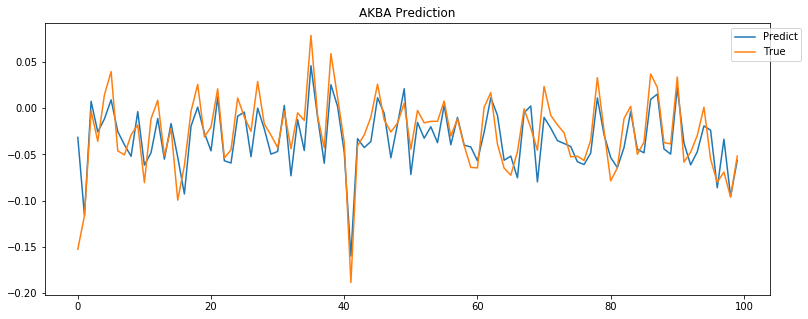

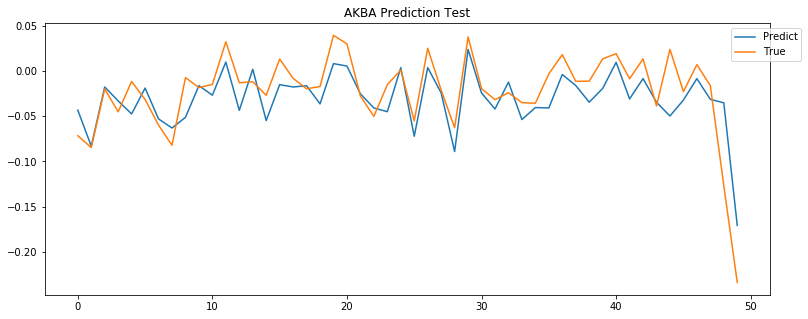

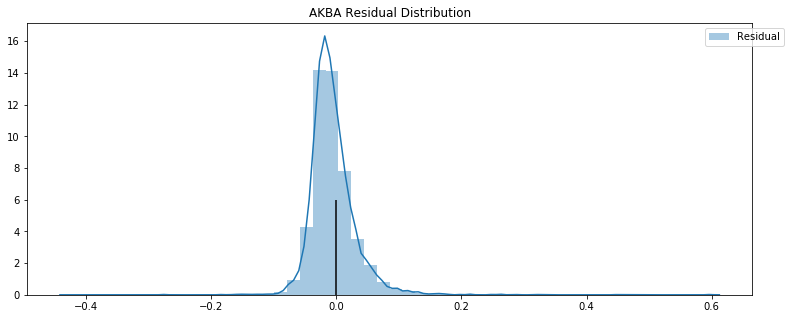

DNLI 0.24900214934392395 0.35521769645959533


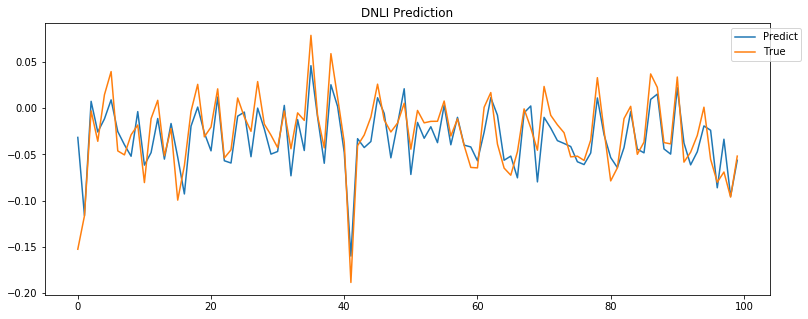

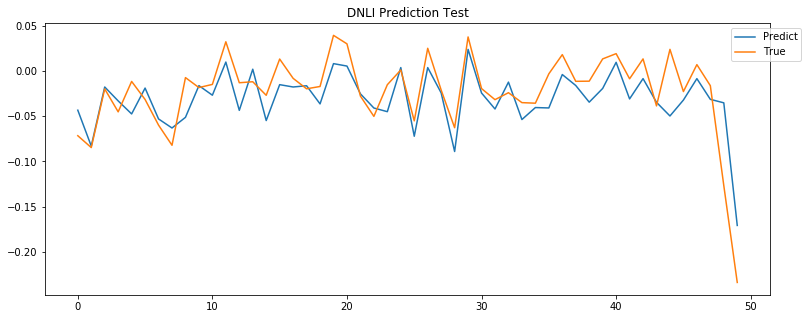

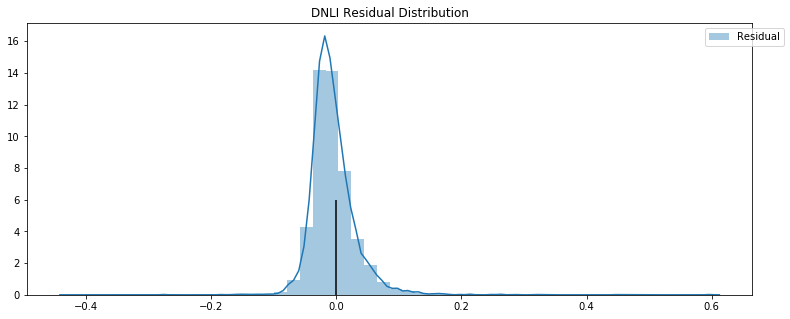

RIGL 0.2490054169388103 0.3552172446963491


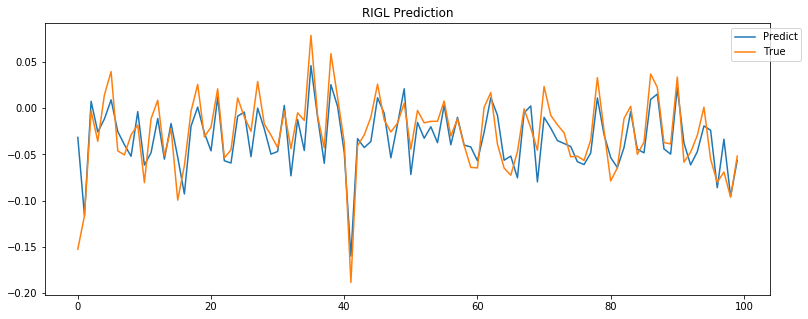

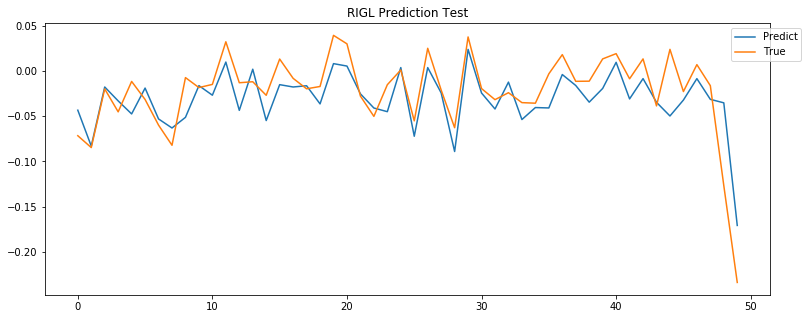

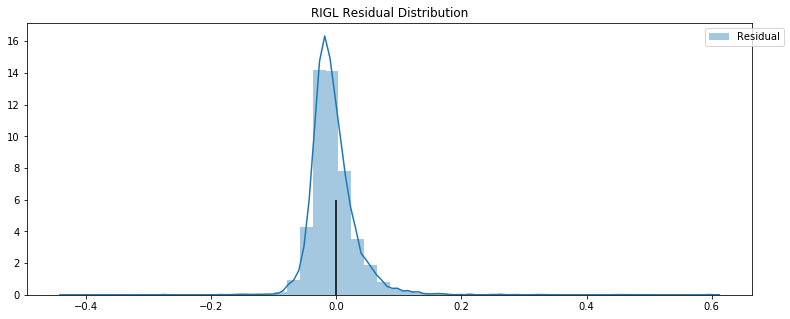

PRNB 0.2490086846898486 0.35521679256714156


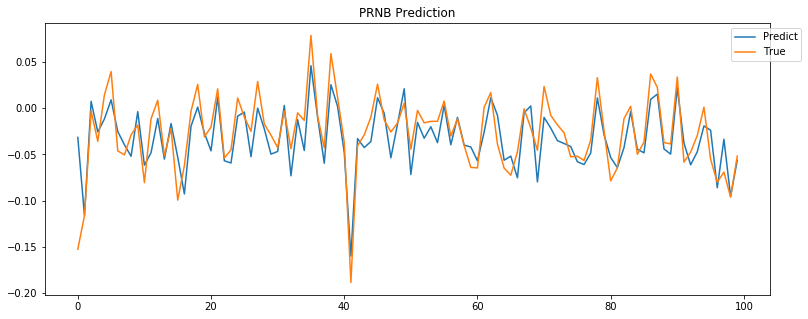

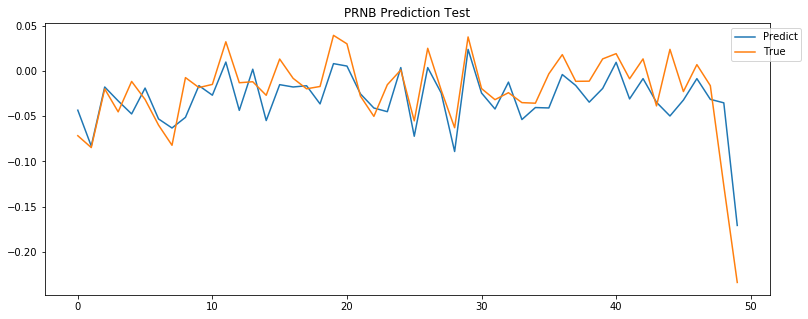

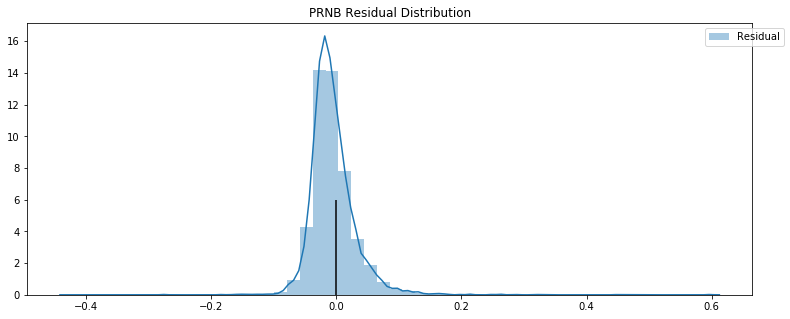

ARVN 0.24901165409277315 0.3552163187315437


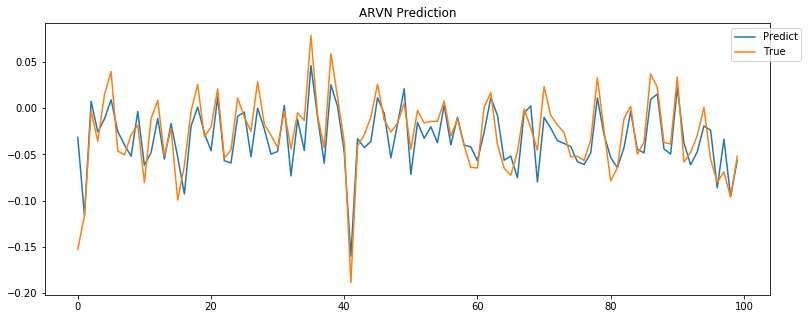

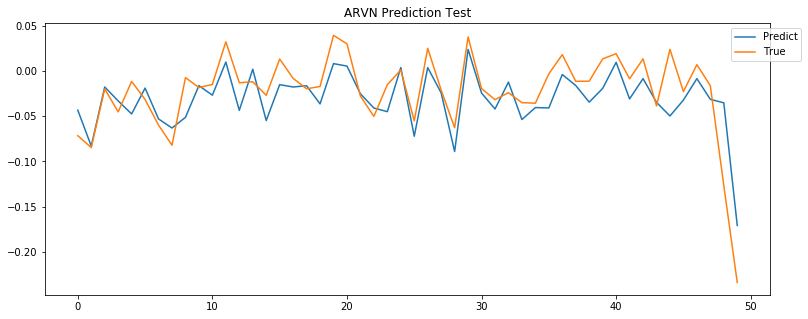

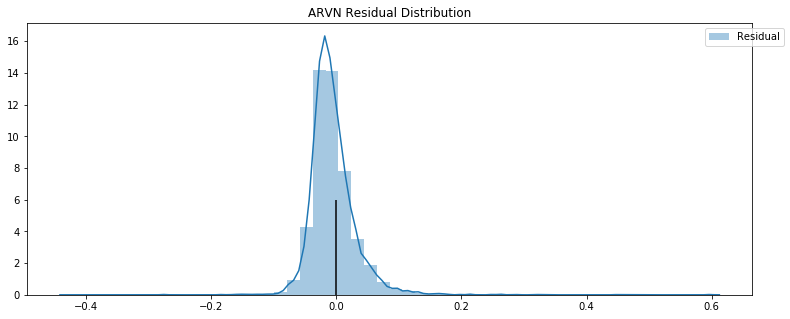

ZYME 0.2490146572232721 0.355215854665337


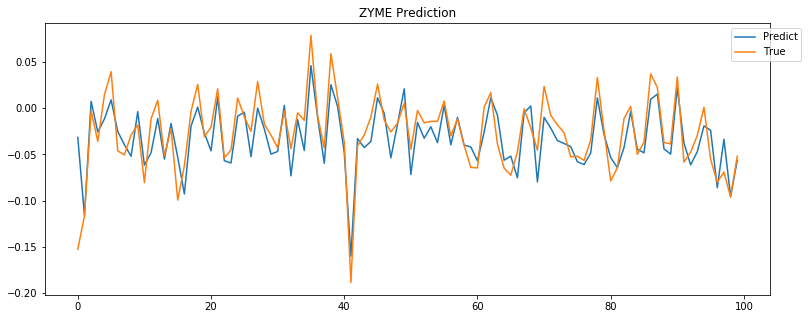

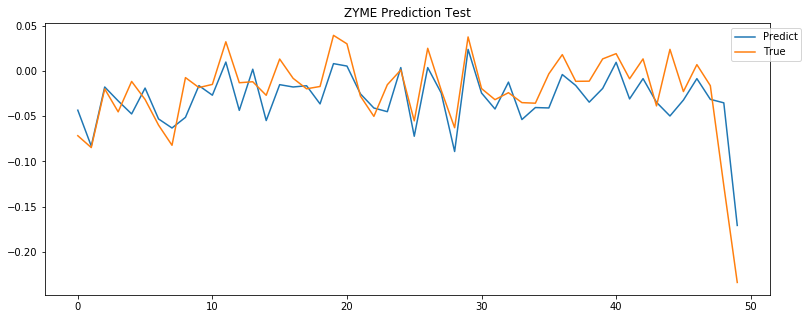

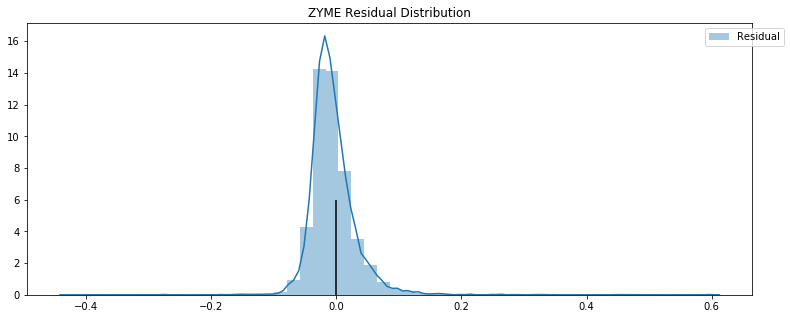

MRNA 0.2490172351360893 0.3552154054009452


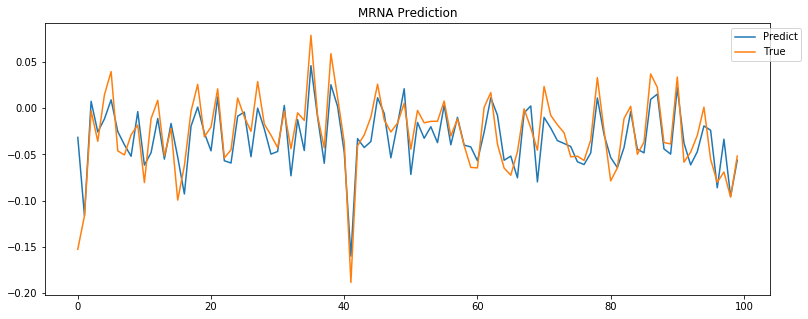

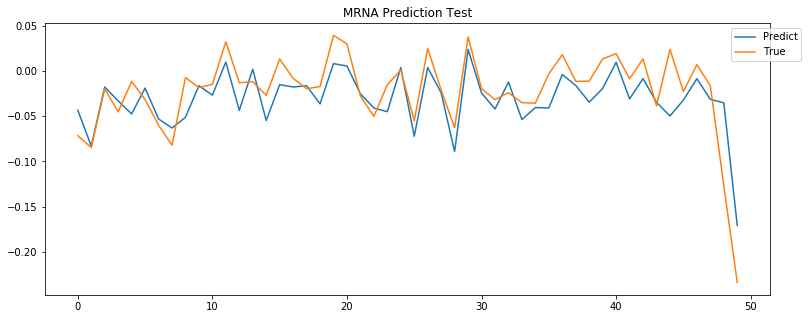

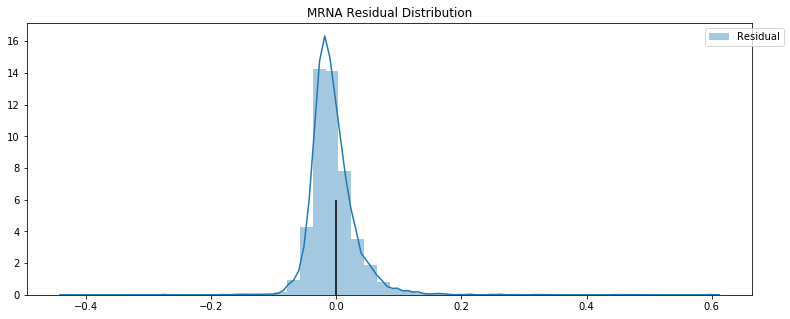

CYTK 0.24901992777100246 0.35521495184955976


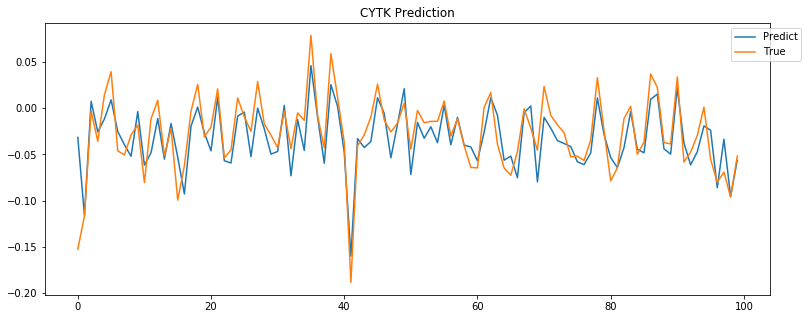

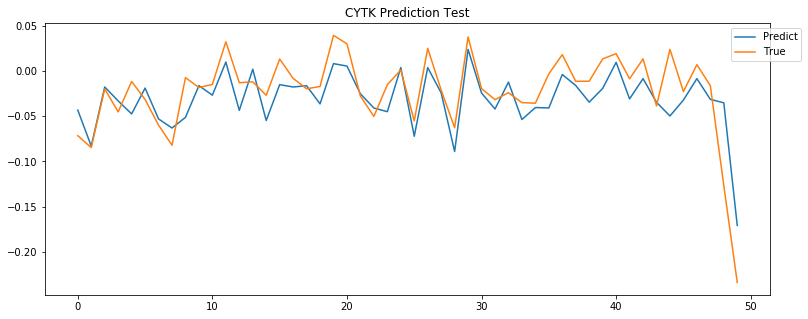

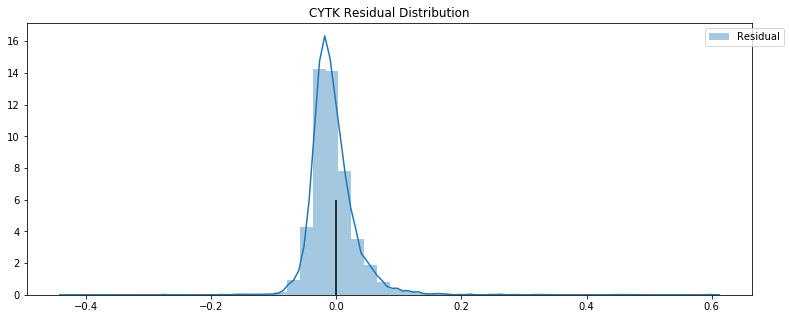

FTSV 0.24902216634088392 0.35521451806170057


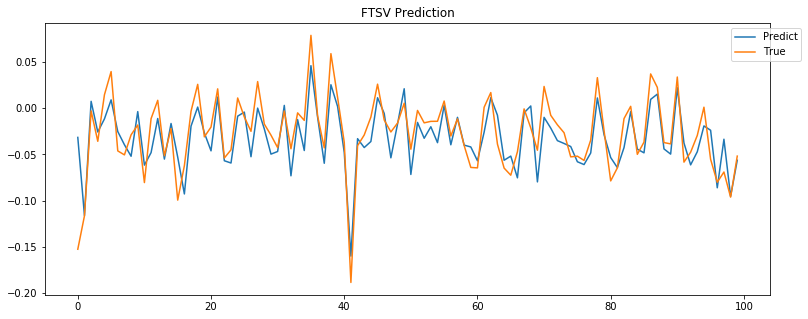

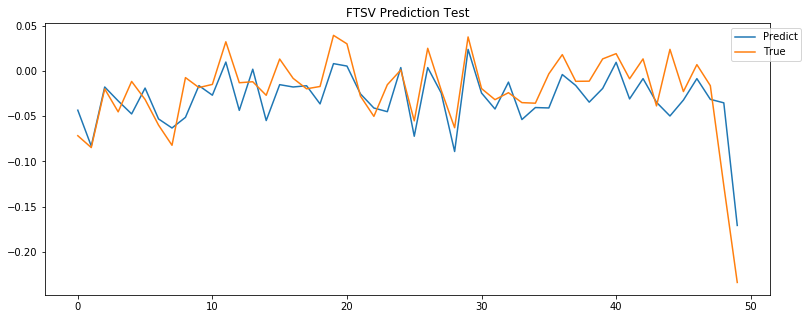

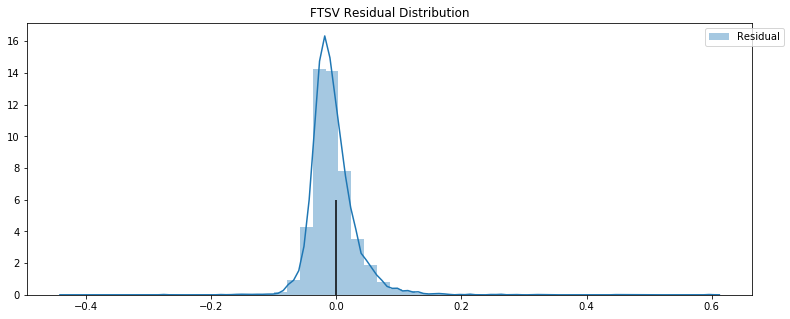

ASND 0.24902439752505212 0.3552140890688844


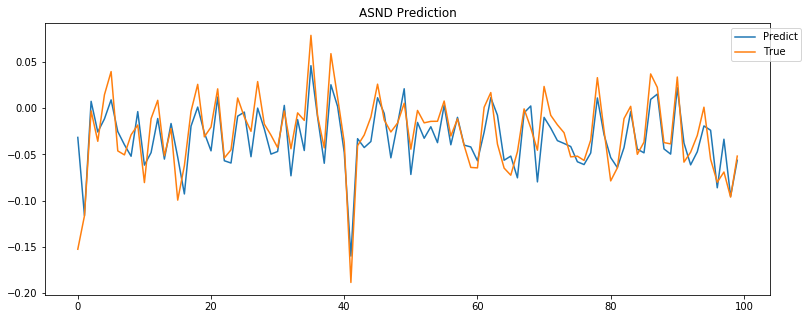

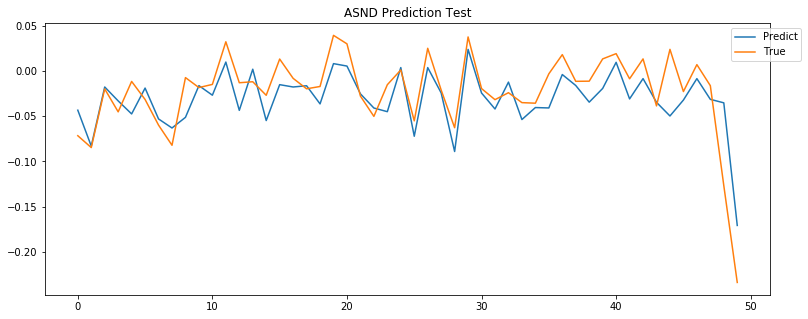

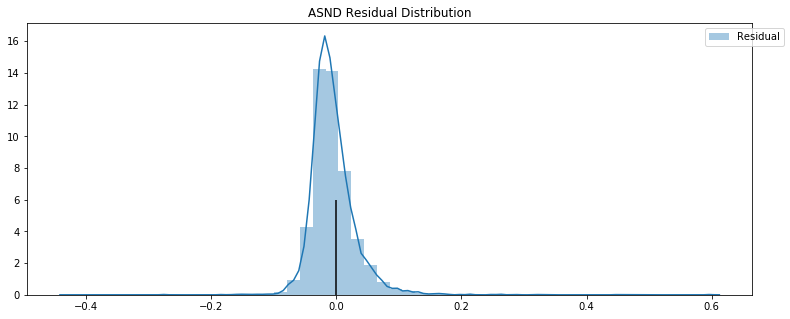

XBIT 0.24902656579041305 0.35521369322932006


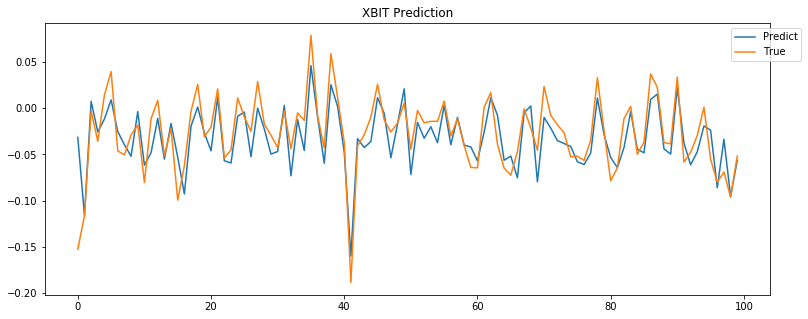

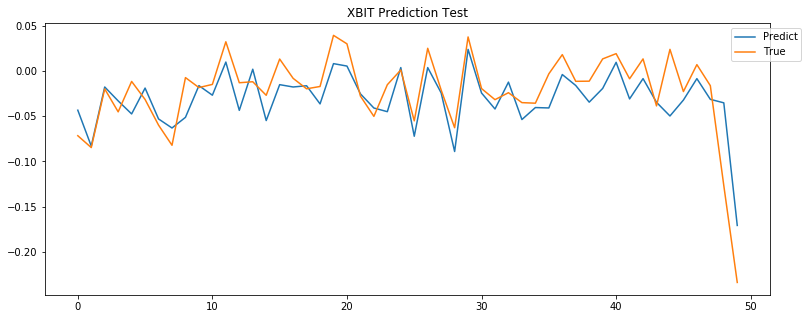

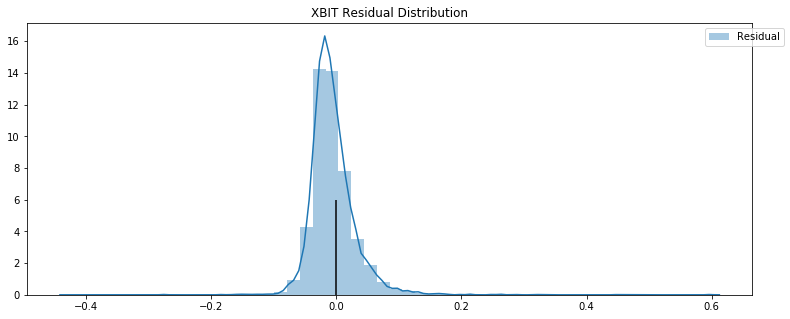

ALEC 0.24902852448457957 0.3552133194209566


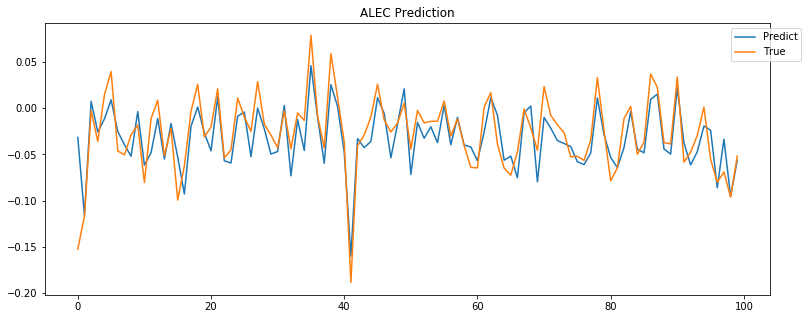

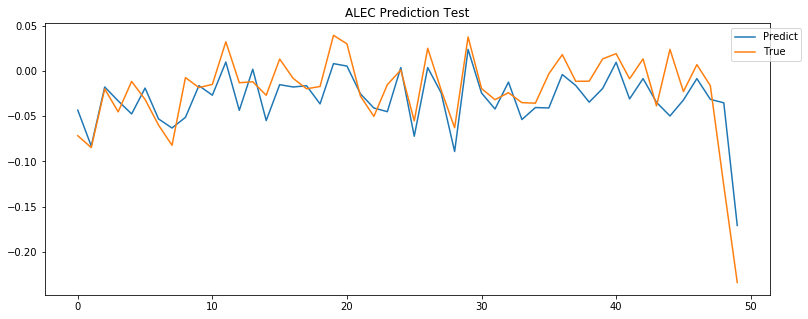

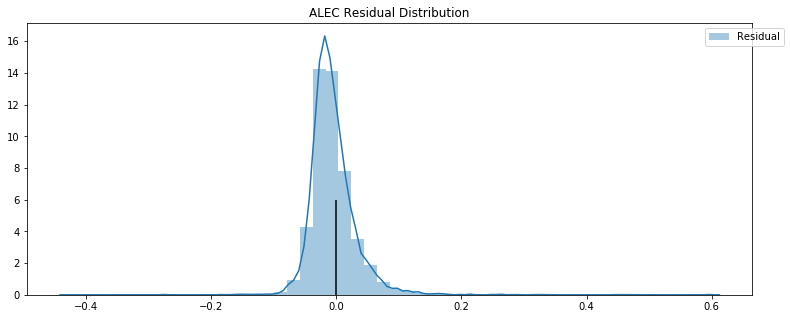

ORTX 0.24903053667560937 0.35521295835990474


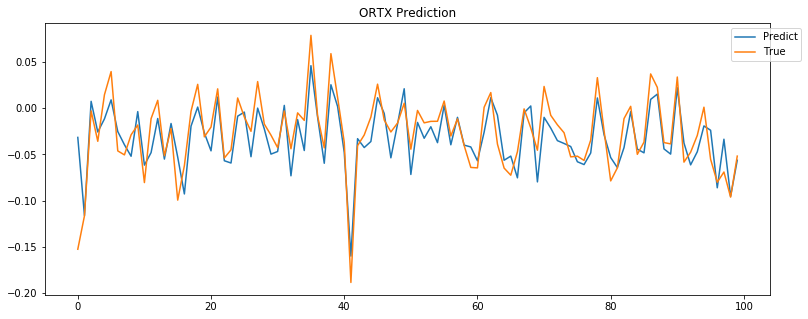

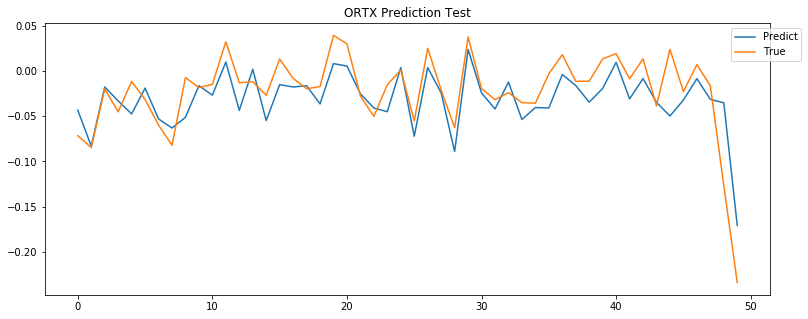

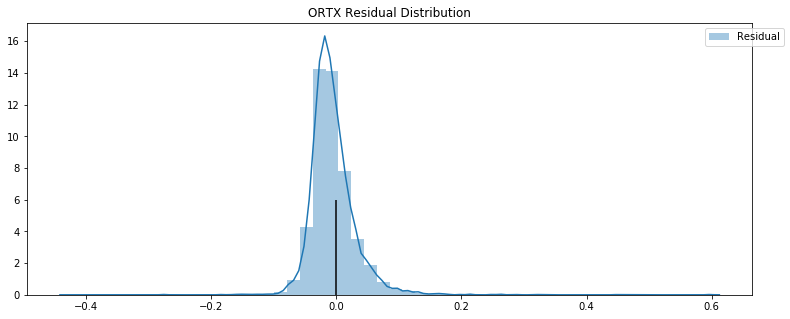

ADVM 0.24903239926709808 0.3552125860933776


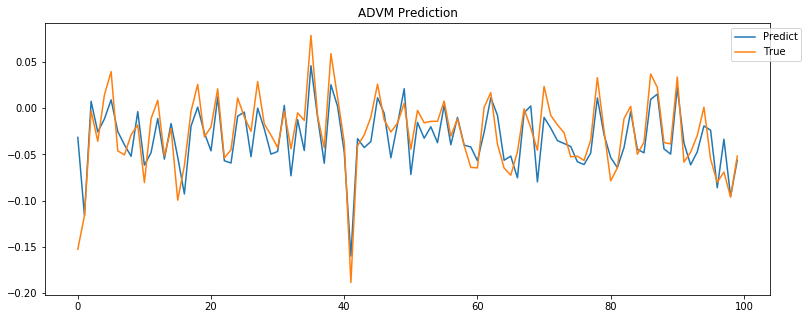

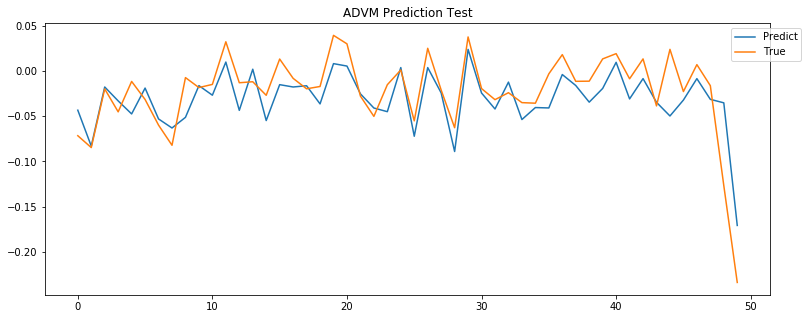

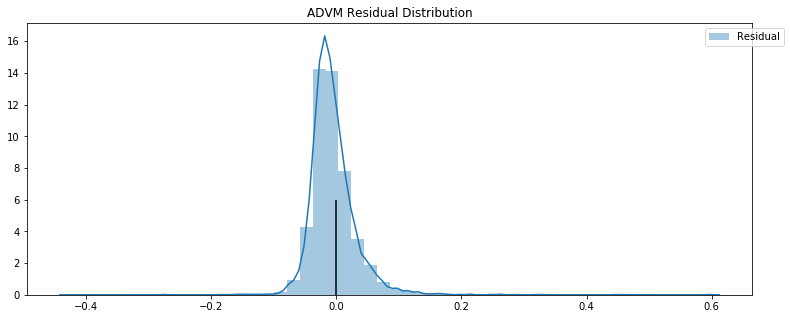

MGNX 0.24903424095858218 0.3552122665332882


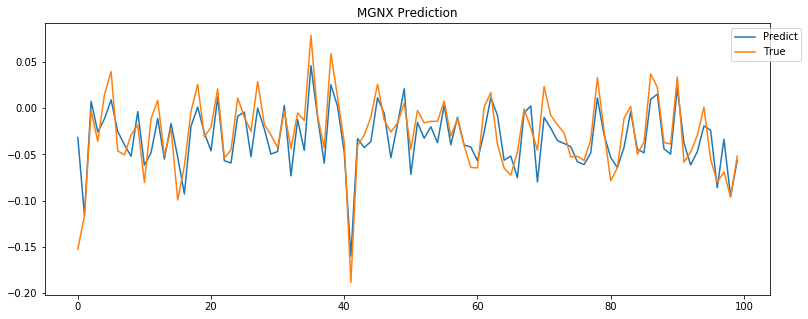

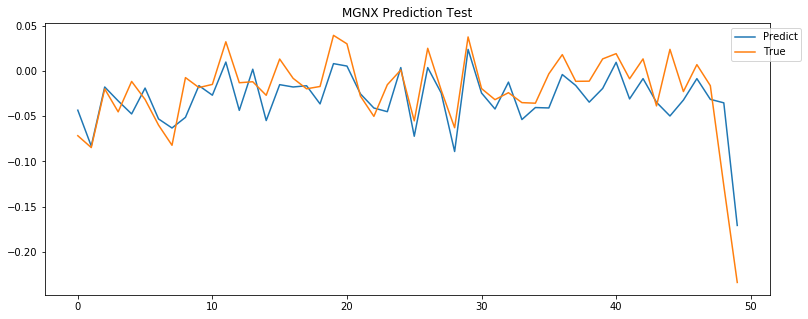

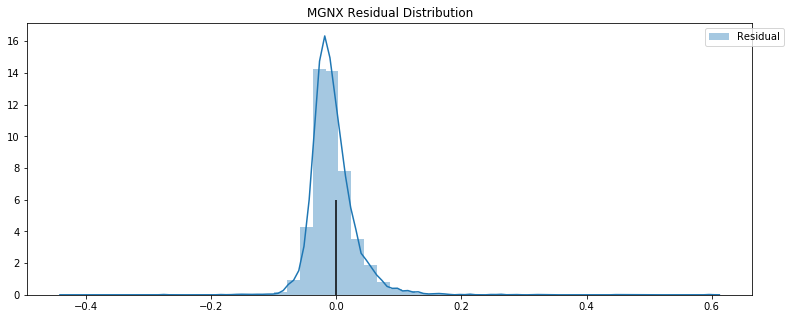

AKRO 0.2490359468786858 0.3552119544754392


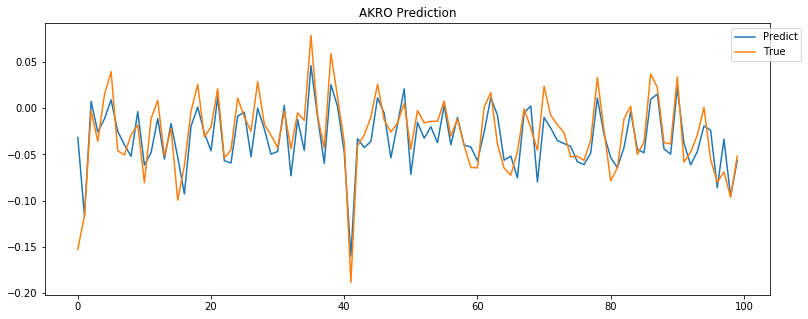

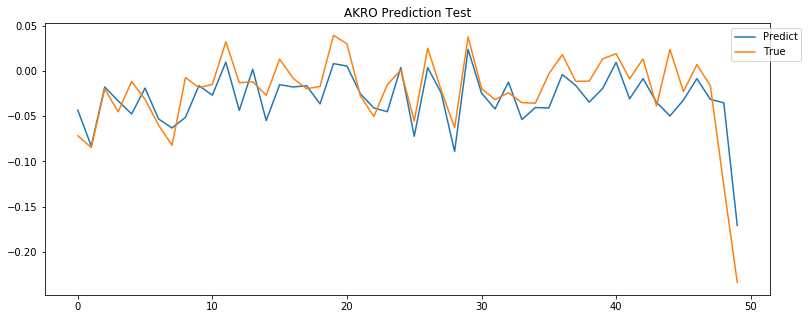

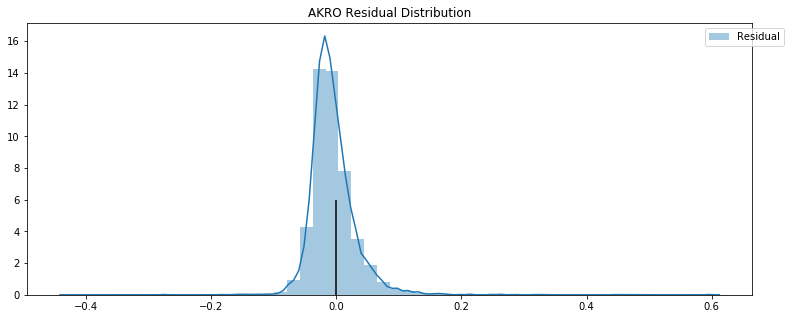

ESPR 0.24903757426245732 0.35521166893180633


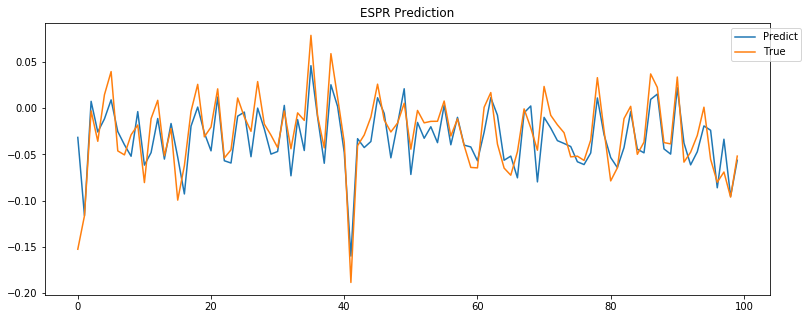

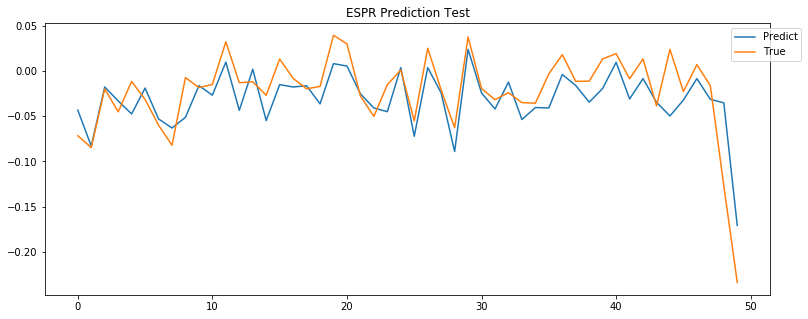

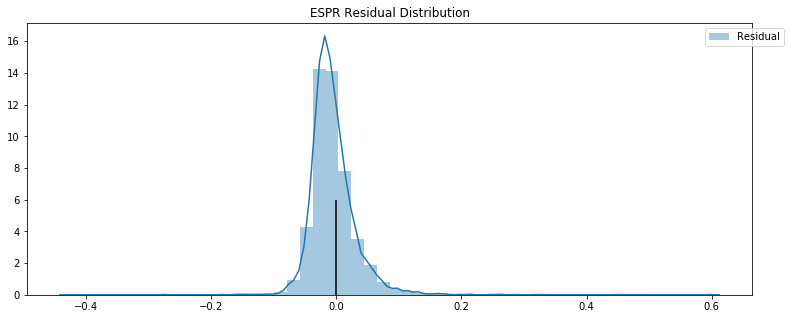

BHVN 0.2490391558809606 0.355211378518819


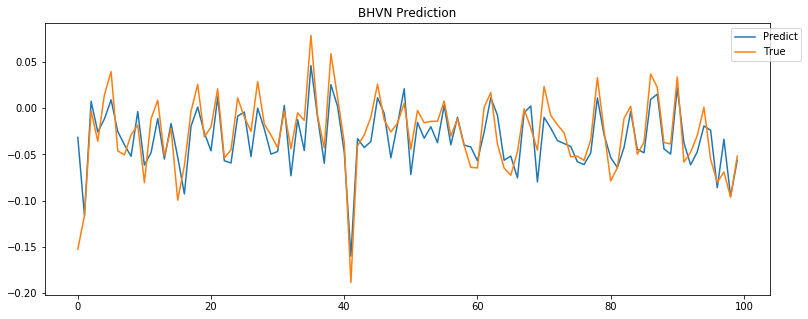

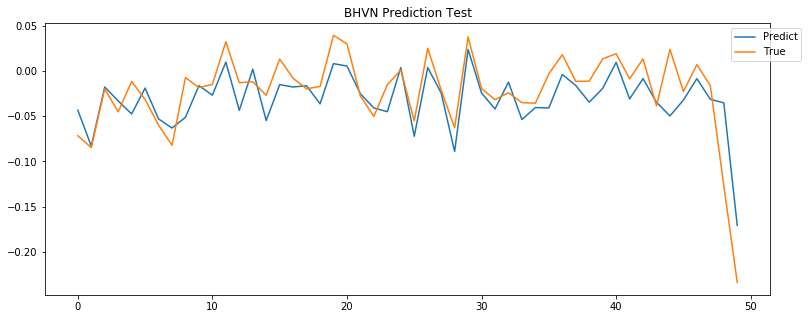

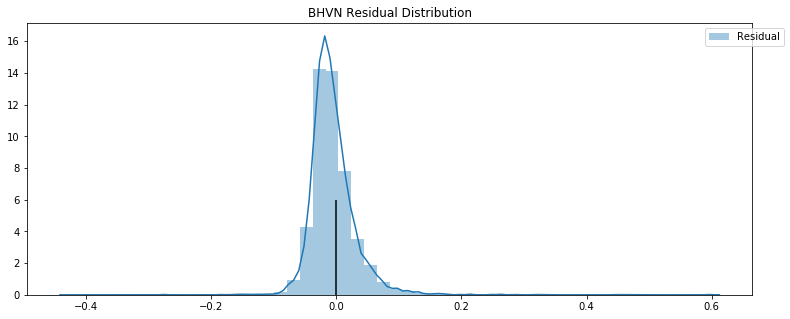

YMAB 0.2490405900181365 0.35521113344187605


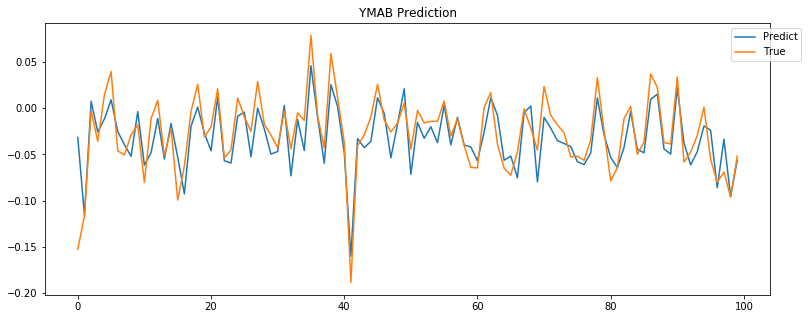

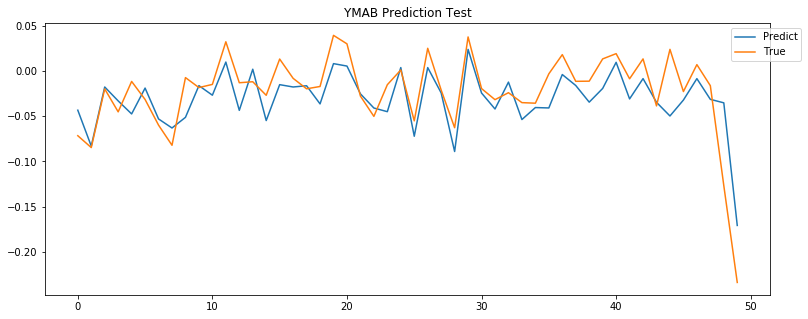

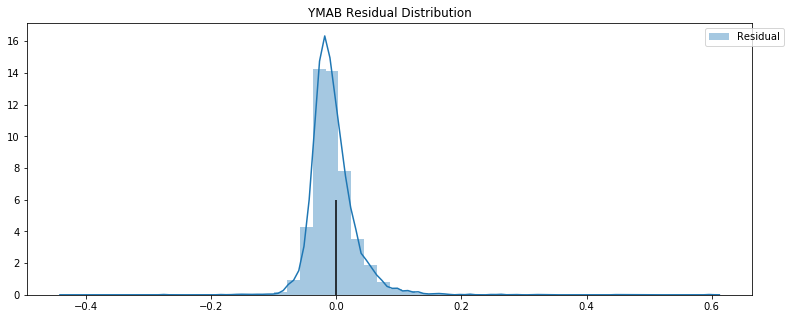

RGNX 0.24904188027055807 0.3552108768414056


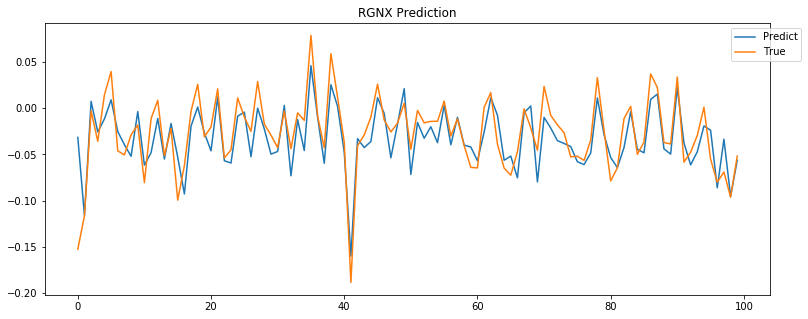

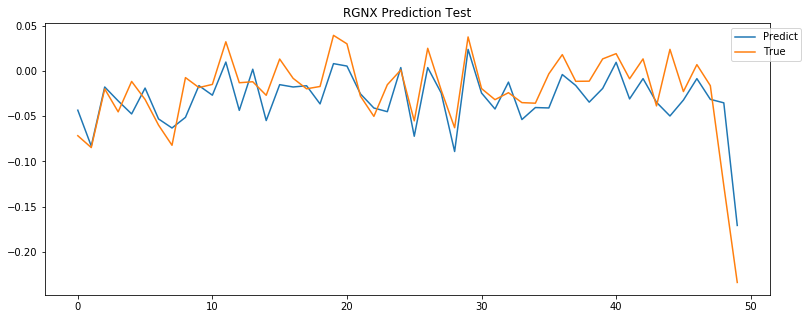

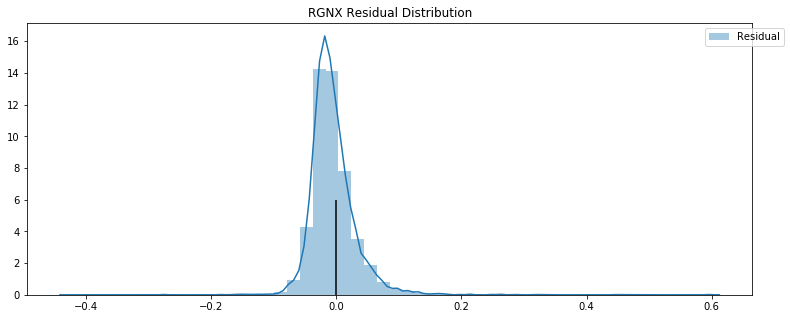

MYOK 0.24904325668507532 0.35521065162094756


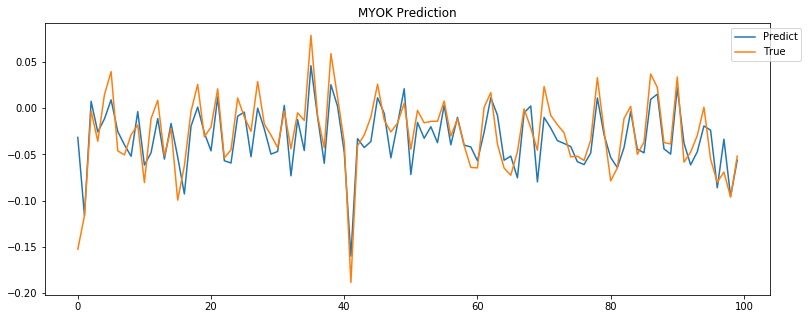

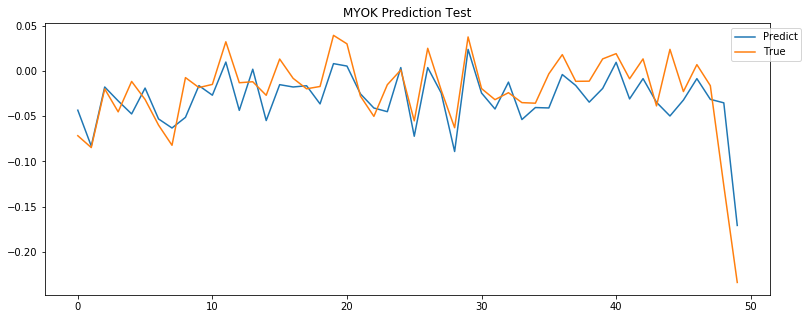

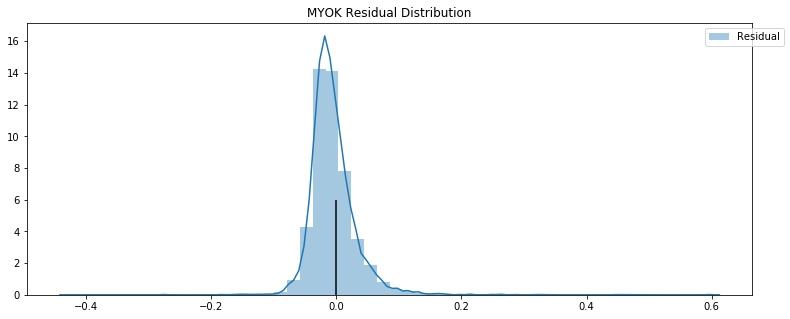

TPTX 0.24904459876258844 0.35521046089764363


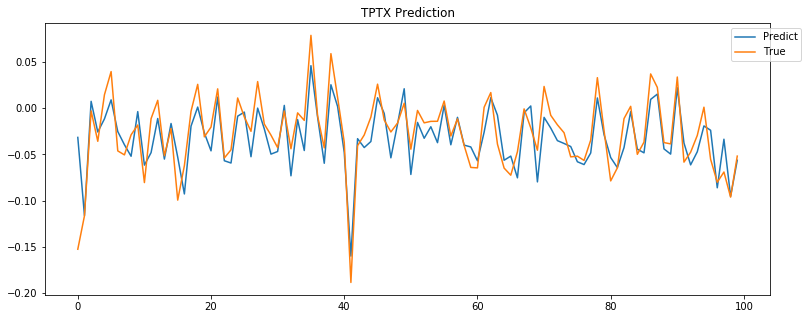

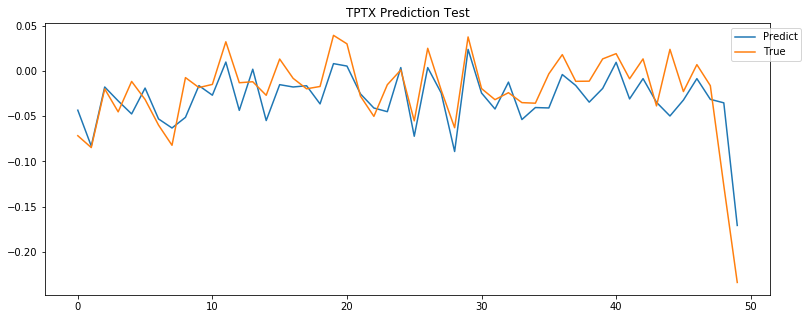

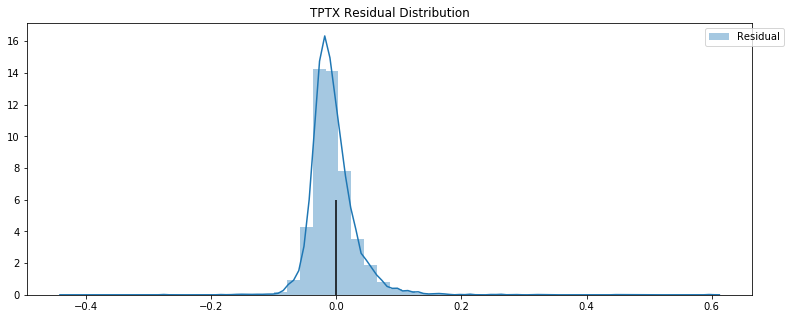

ATNX 0.2490457990575956 0.35521024506447496


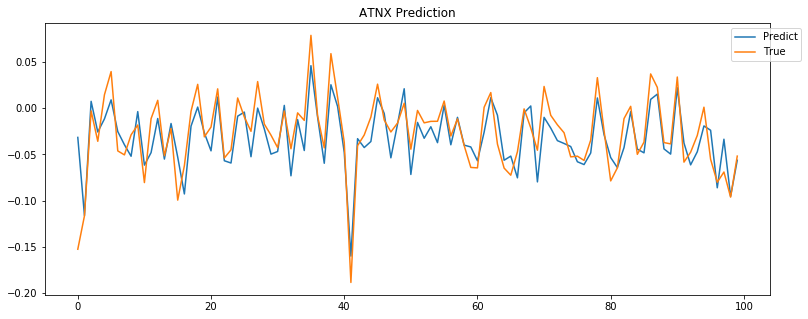

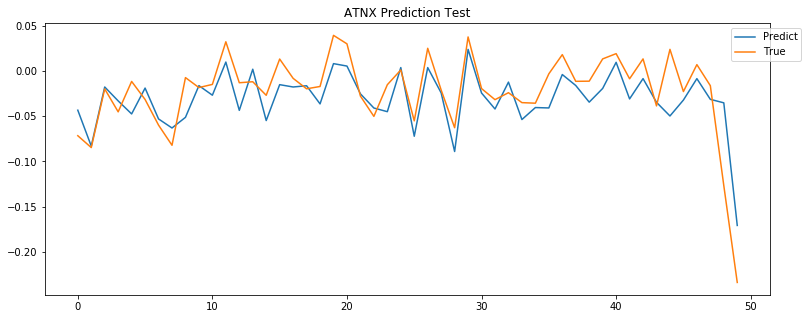

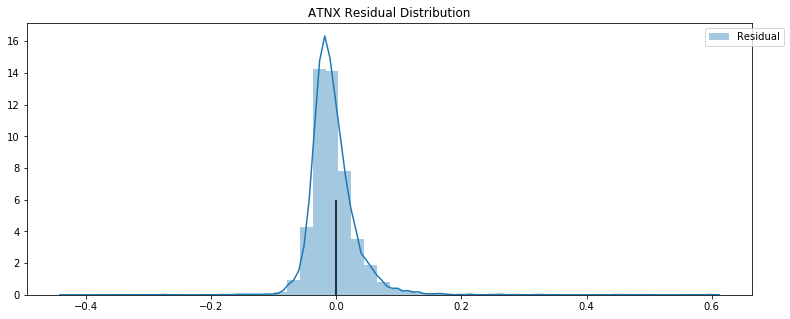

BLUE 0.24904699575433553 0.35521006303586966


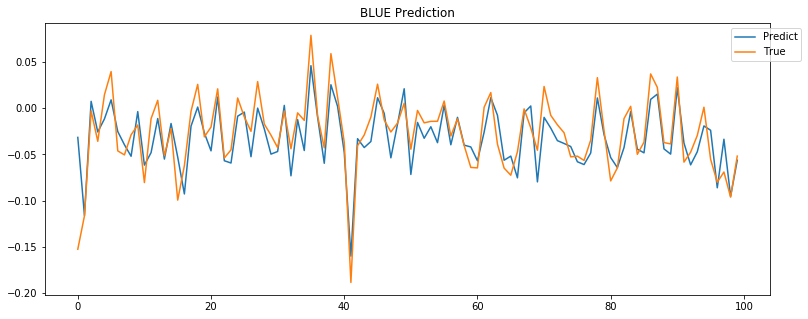

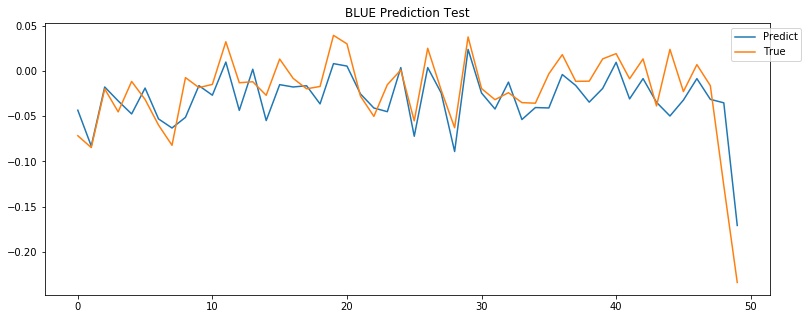

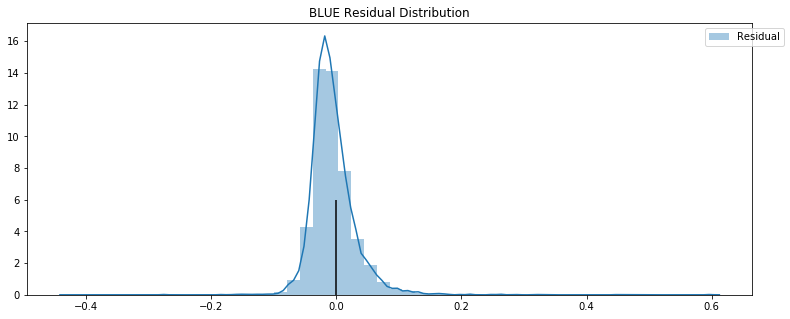

AGEN 0.2490481834214089 0.35520987354428135


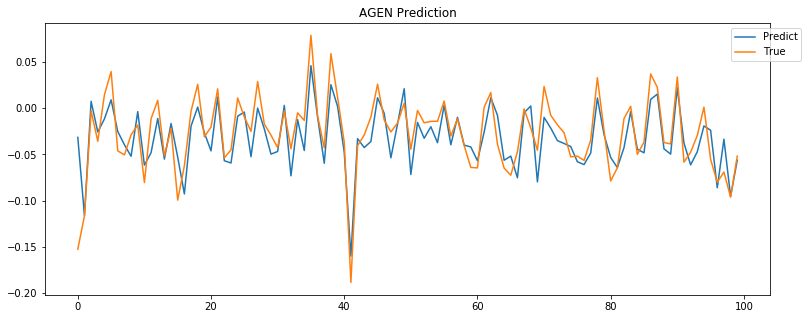

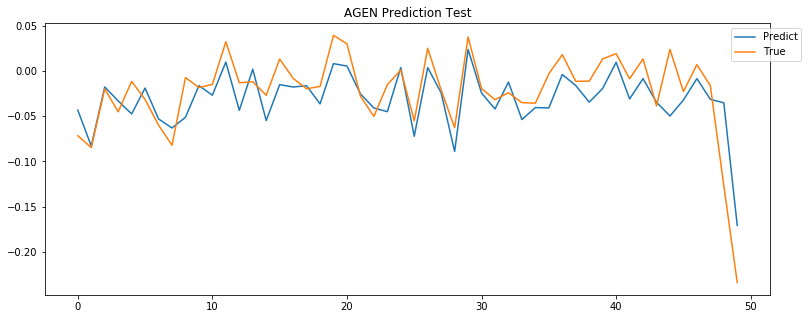

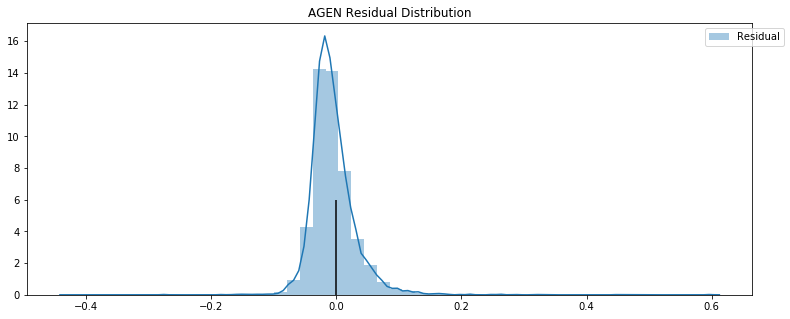

AVRO 0.24904920195085456 0.3552097191380349


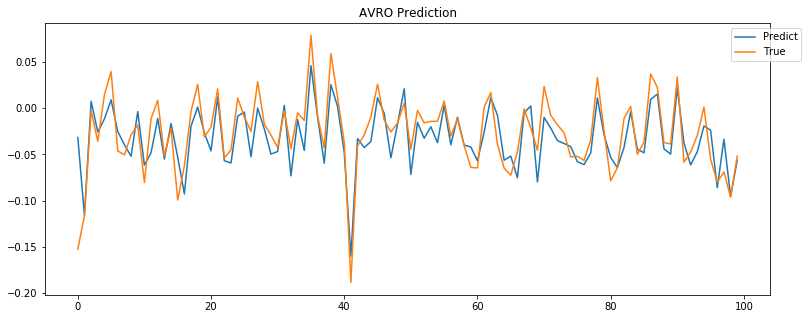

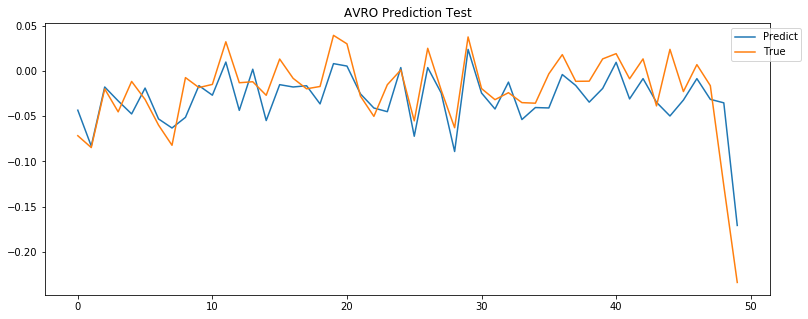

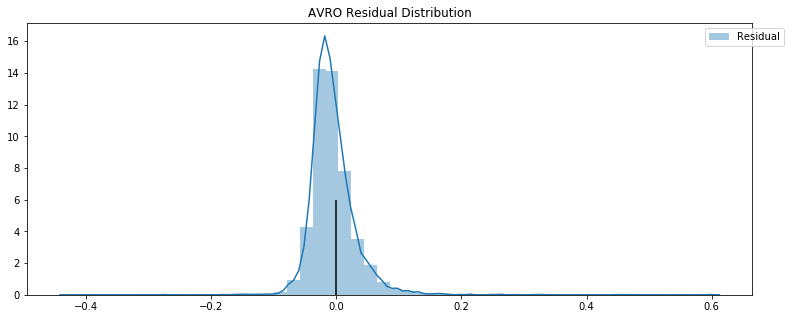

DCPH 0.24905020230471508 0.3552095855821581


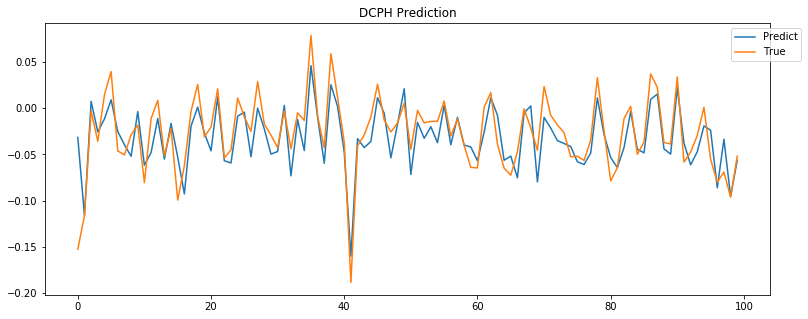

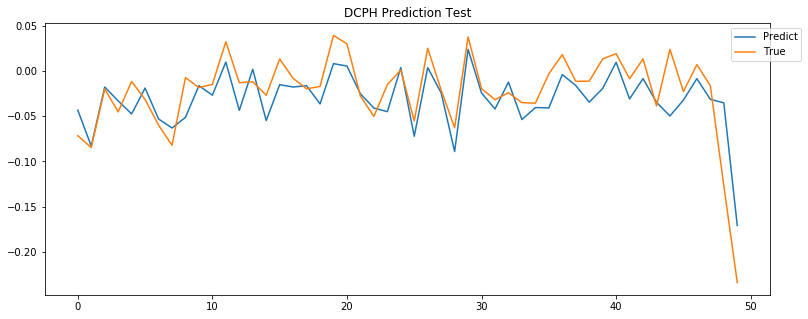

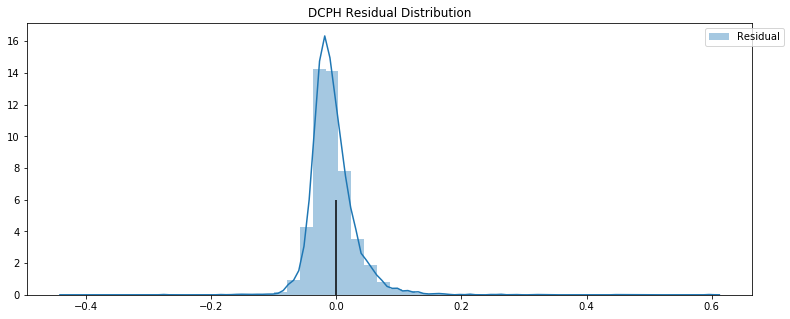

CTMX 0.24905115728110738 0.35520942769981045


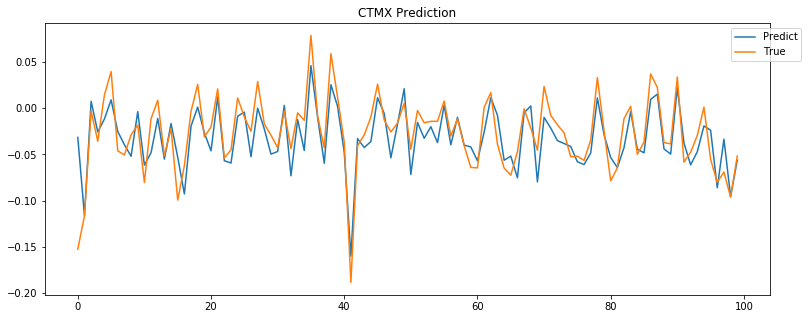

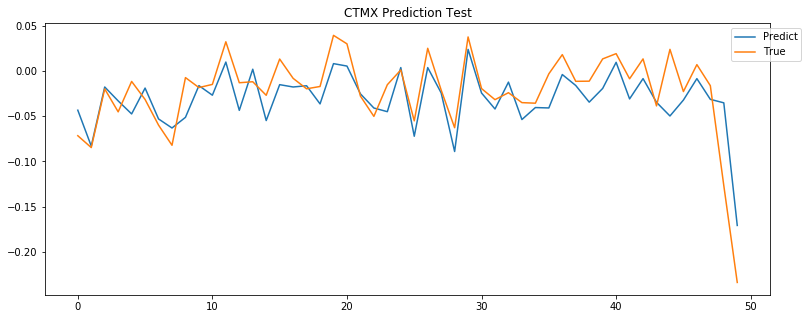

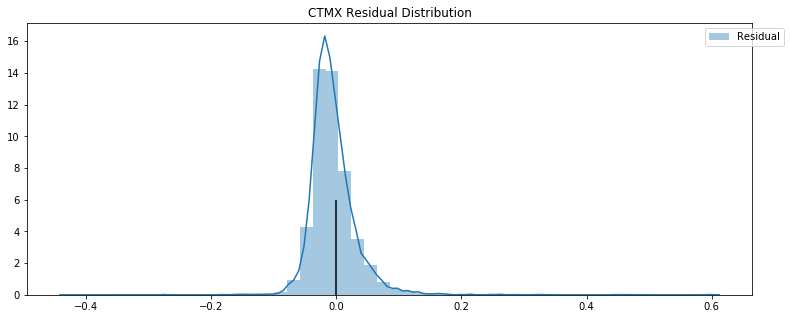

SRNE 0.24905199967667058 0.35520931110277654


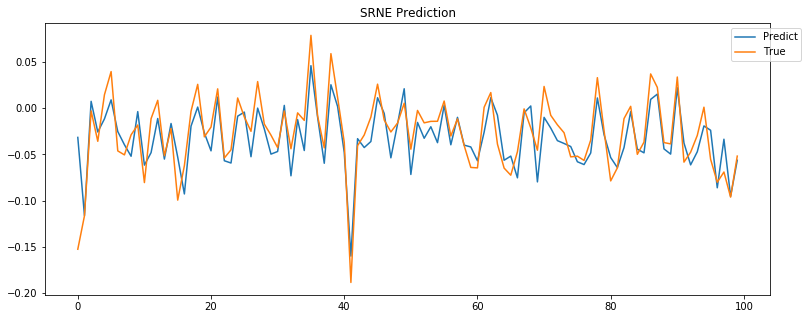

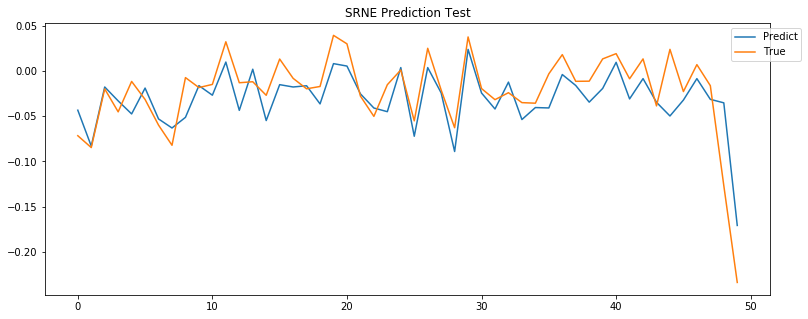

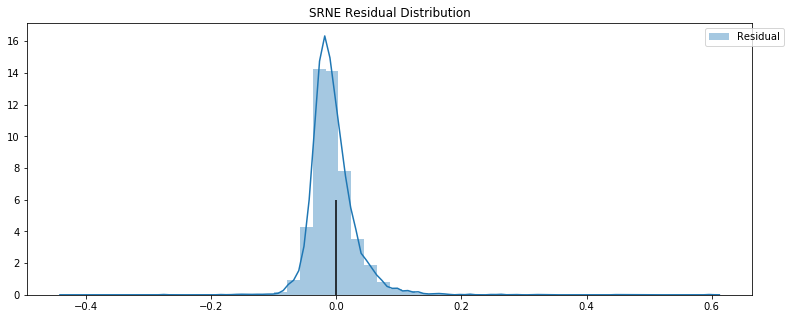

ARDX 0.24905276798528275 0.35520918832350645


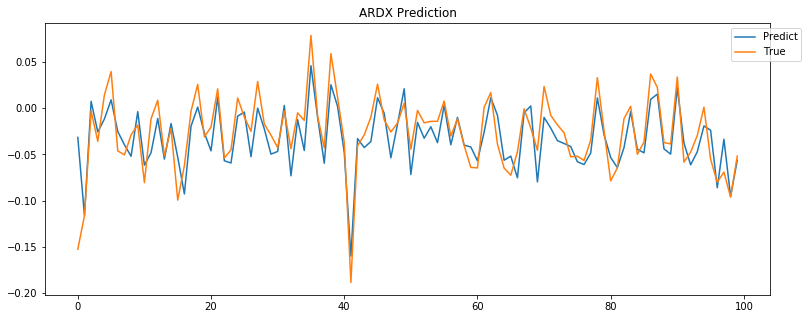

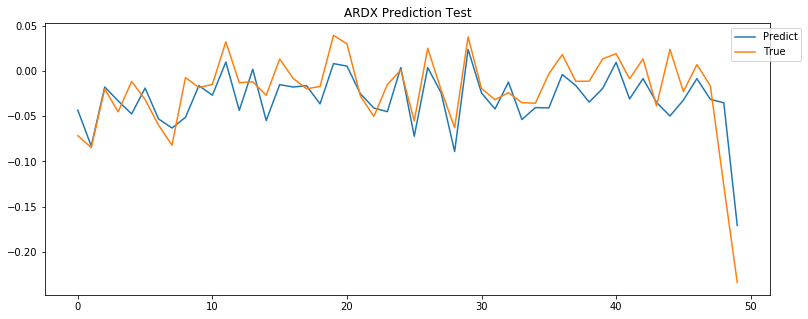

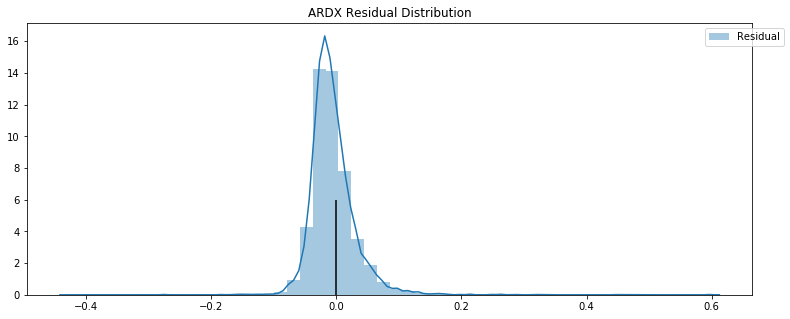

BCRX 0.24905369008928713 0.3552090579583883


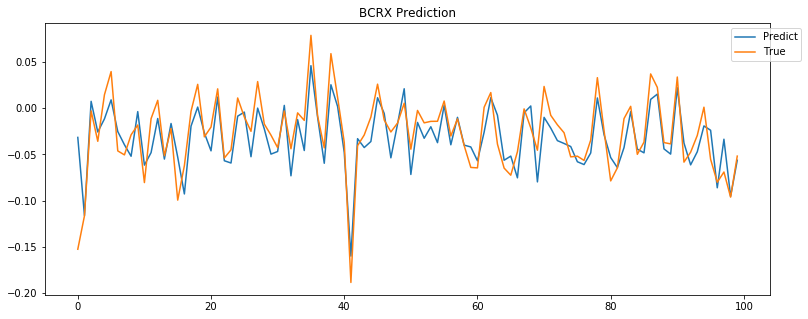

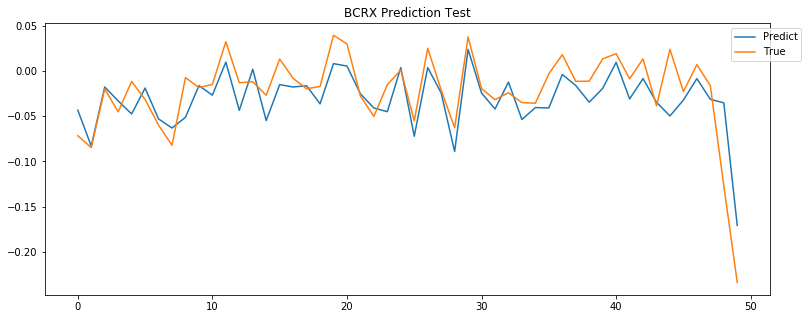

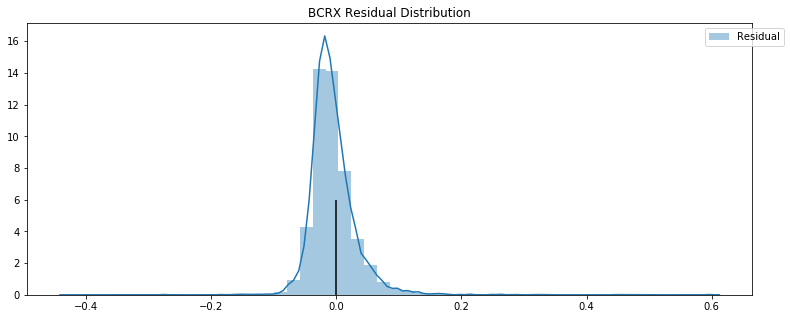

RETA 0.2490543658828136 0.35520895248469897


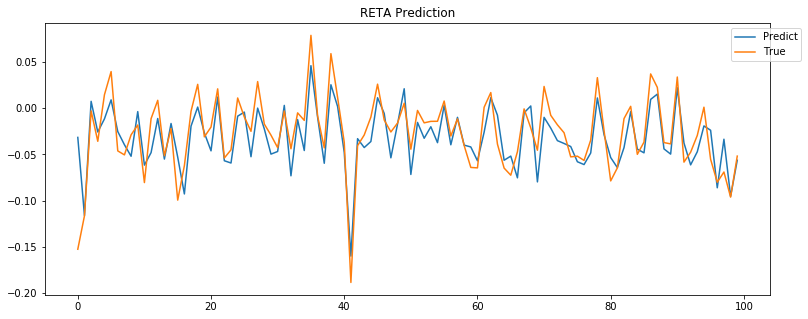

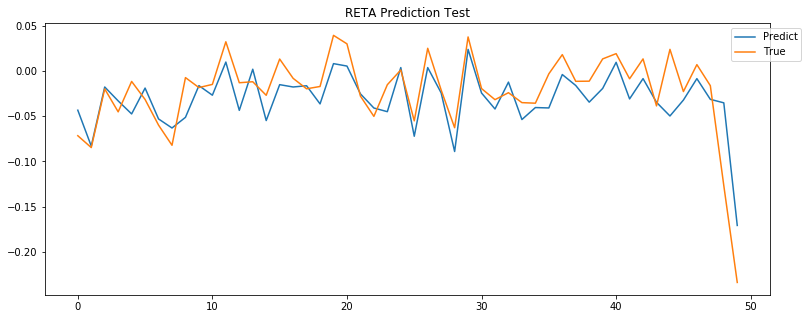

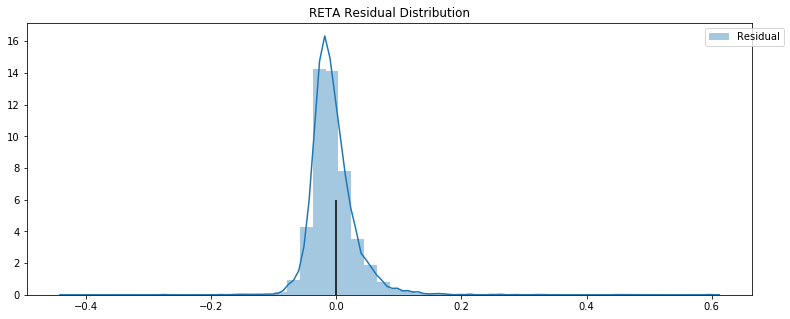

KOD 0.24905522867015117 0.35520884317831813


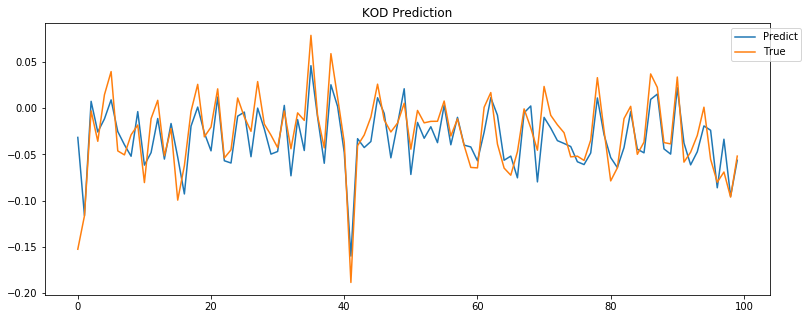

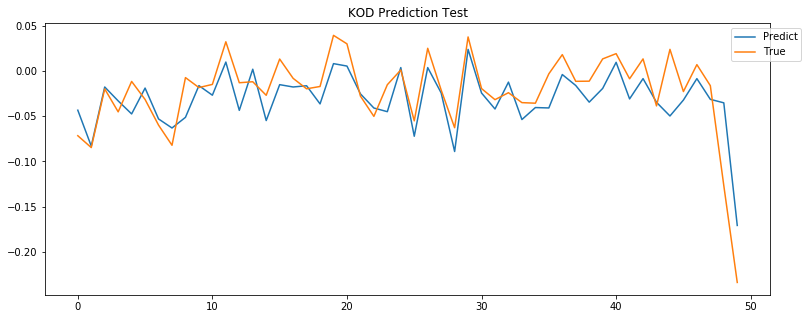

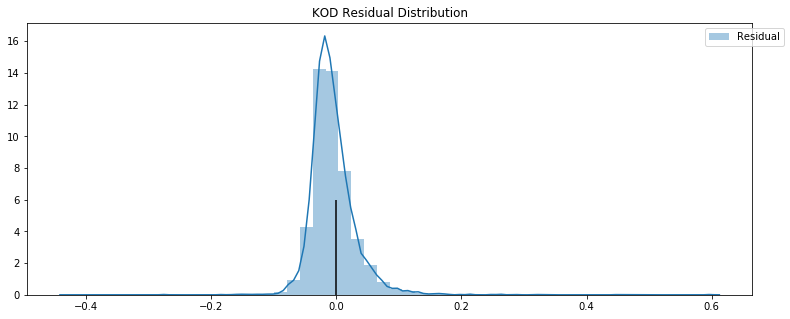

DTIL 0.2490559976905271 0.35520874844765227


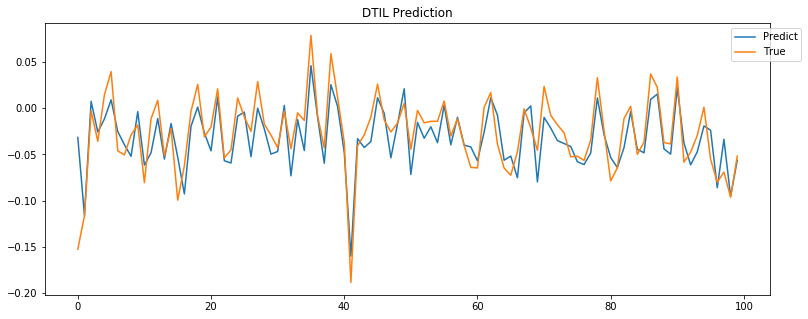

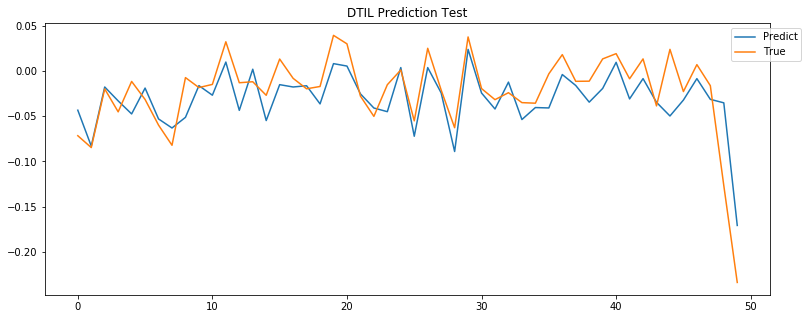

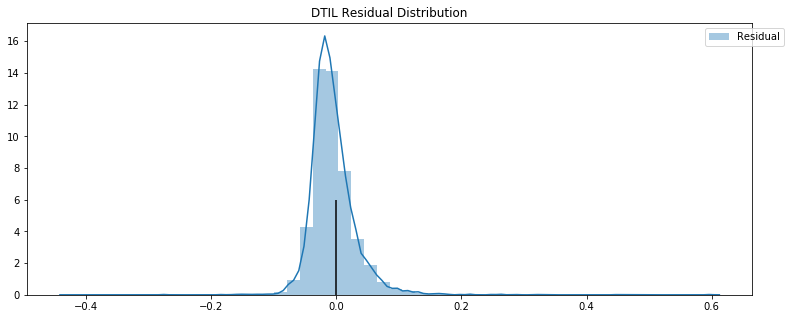

RARX 0.249056566383427 0.35520868964435537


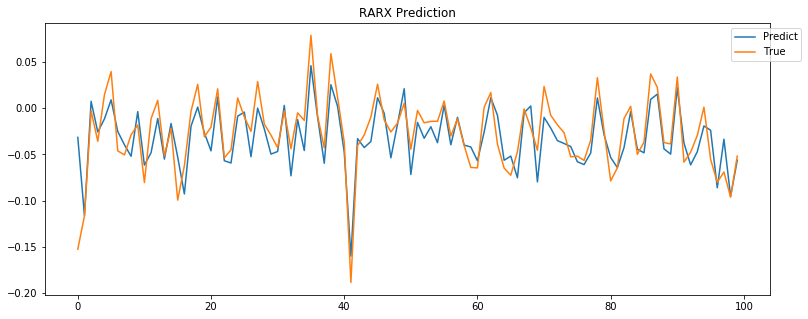

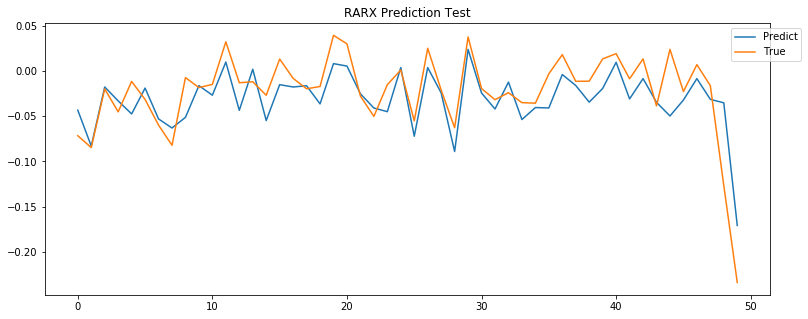

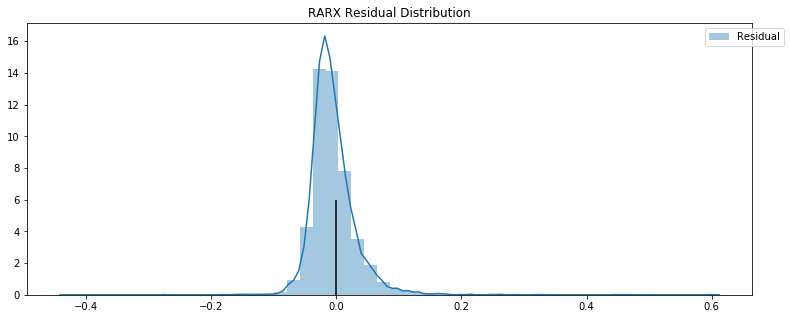

AUTL 0.2490572978757133 0.3552085995242713


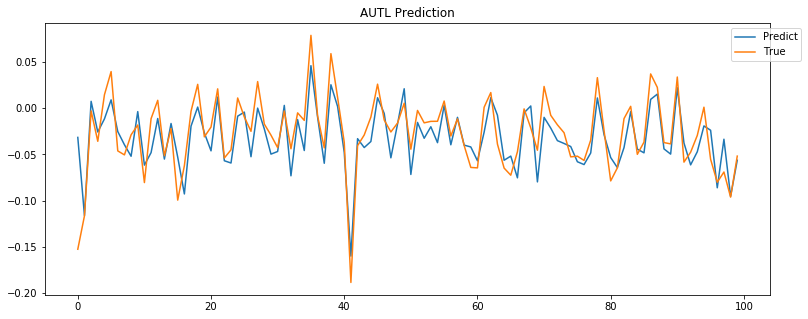

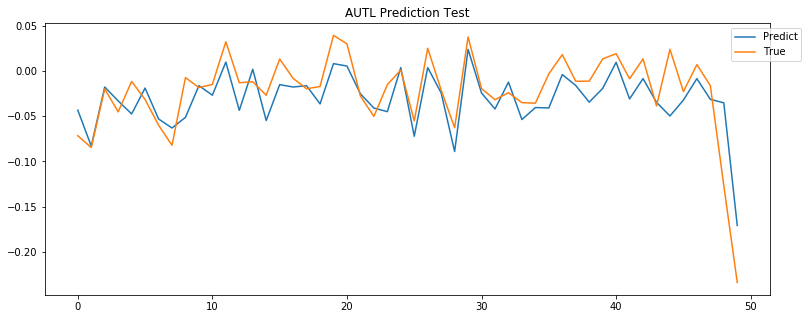

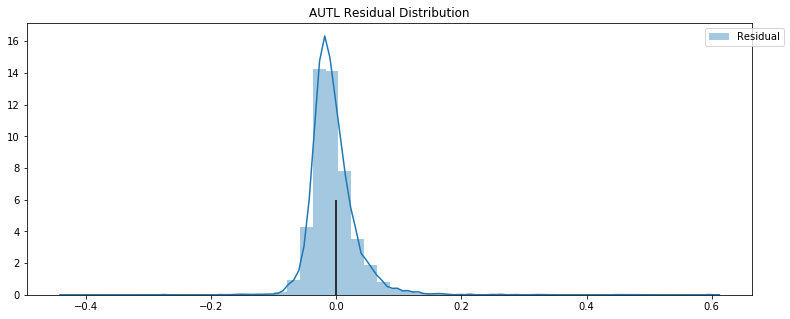

GTHX 0.24905790782510273 0.35520853605220537


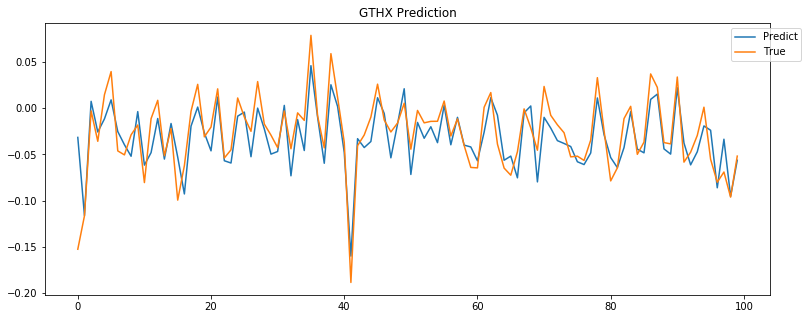

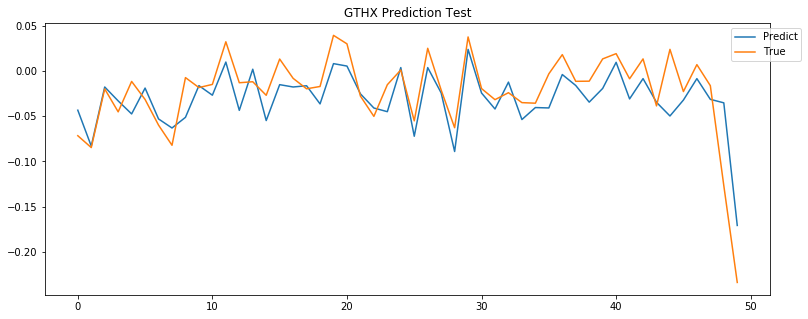

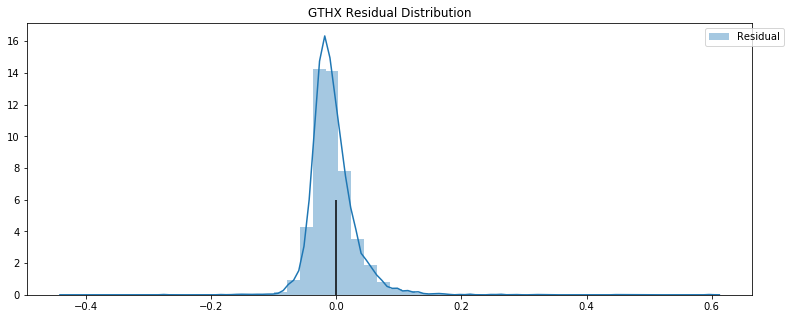

CARA 0.24905854730829513 0.3552084542983077


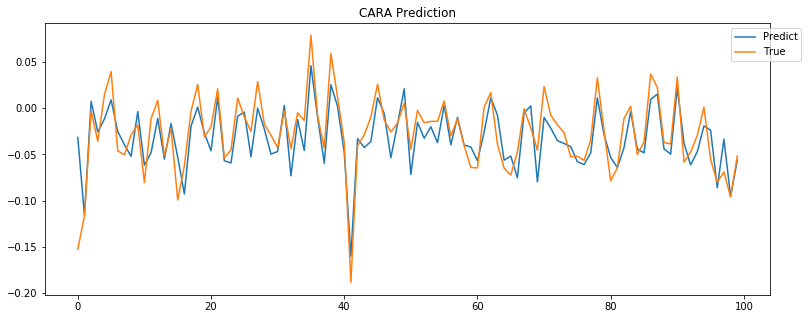

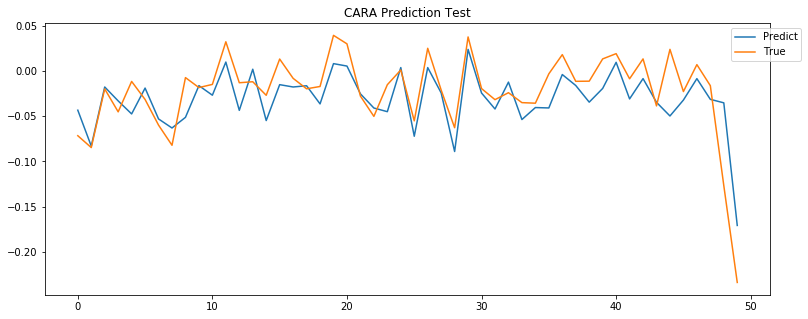

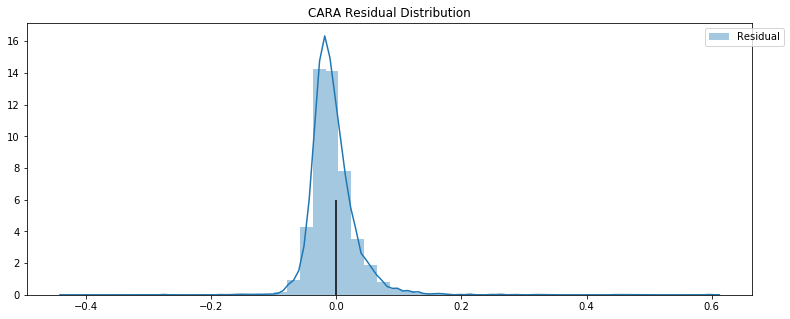

KDMN 0.24905908754832518 0.3552084084746715


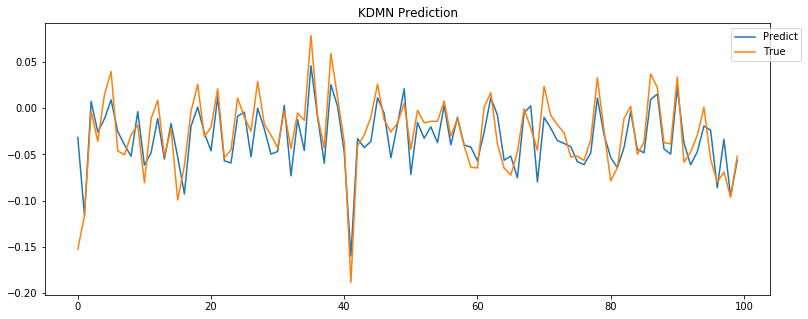

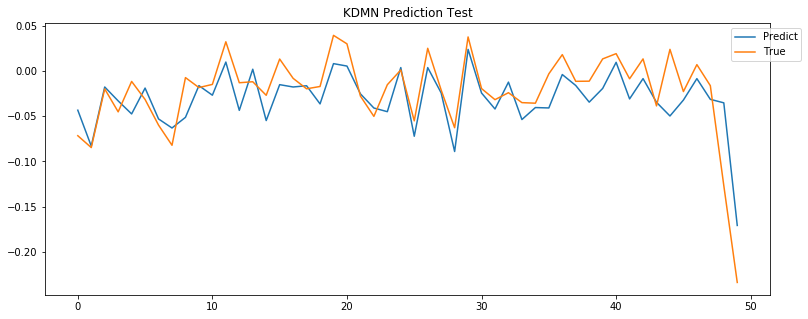

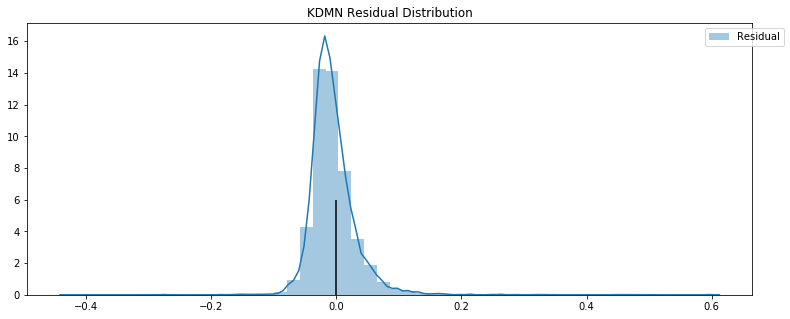

XNCR 0.24905966301127214 0.355208335730847


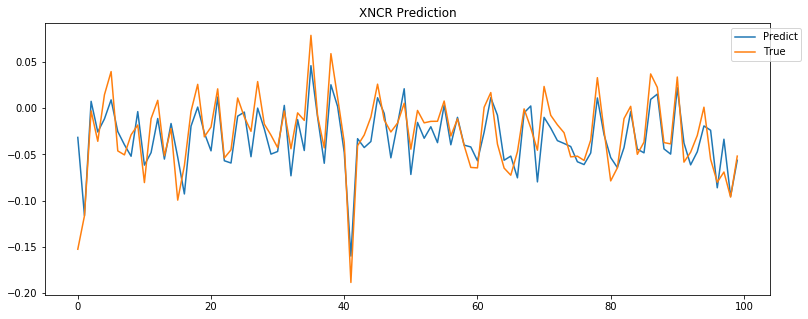

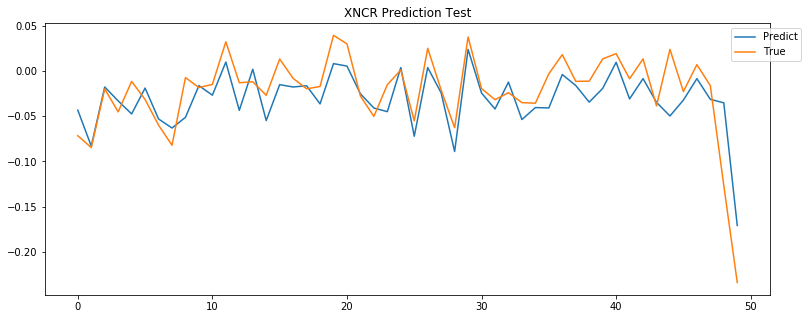

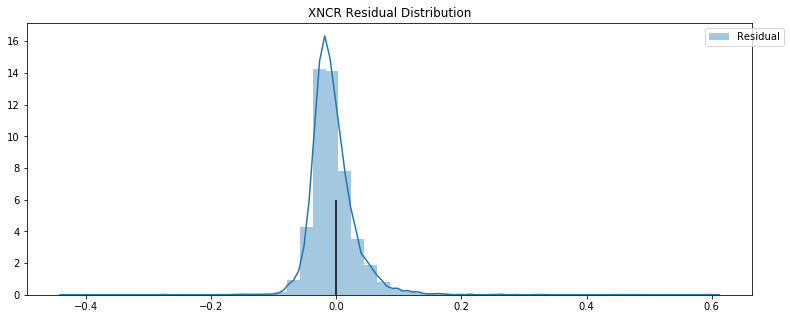

ACHN 0.24906012415786472 0.3552082780704263


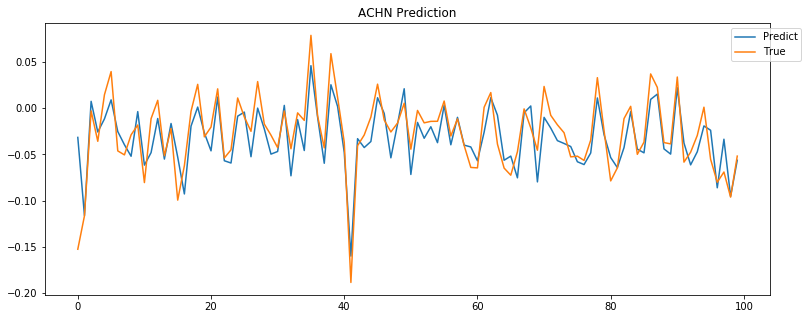

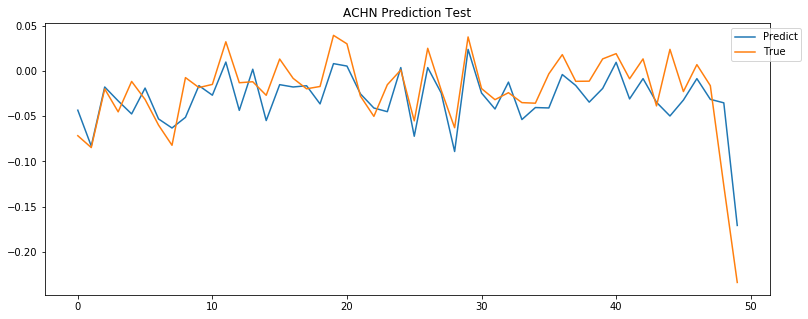

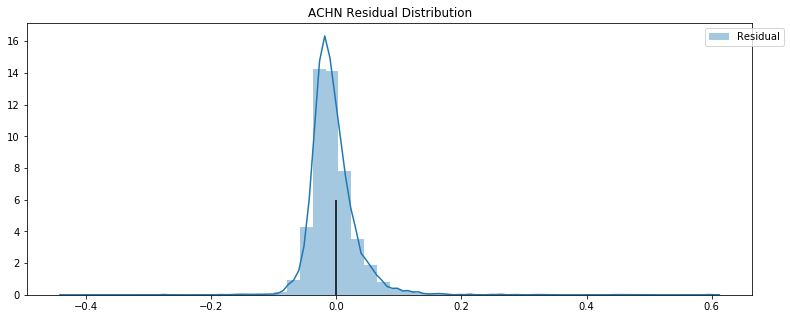

ARNA 0.24906056622371242 0.3552082168703091


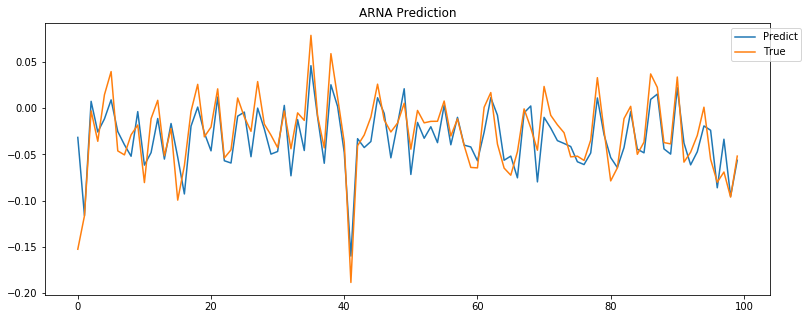

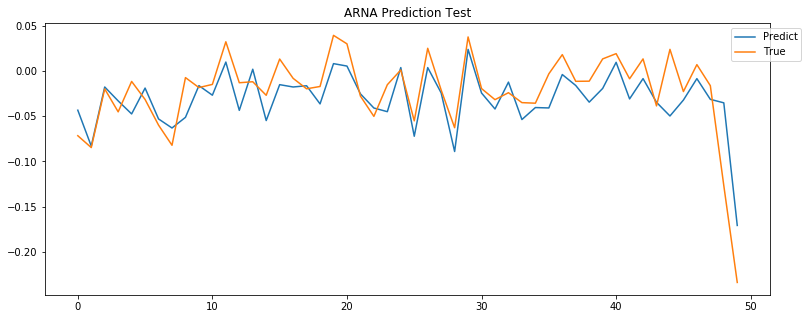

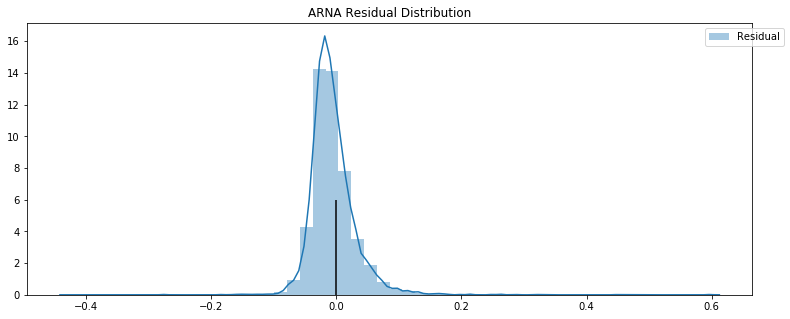

RCKT 0.24906103545177394 0.35520819591680275


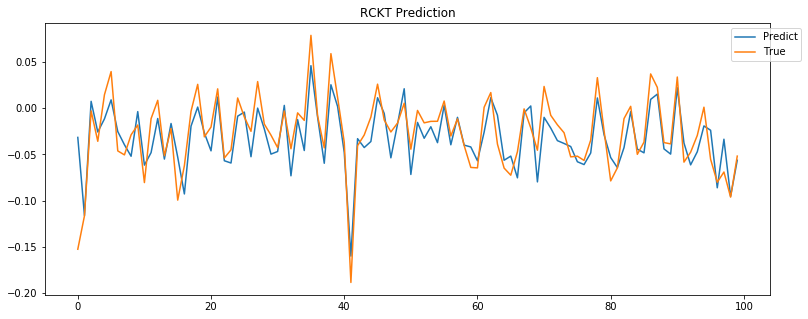

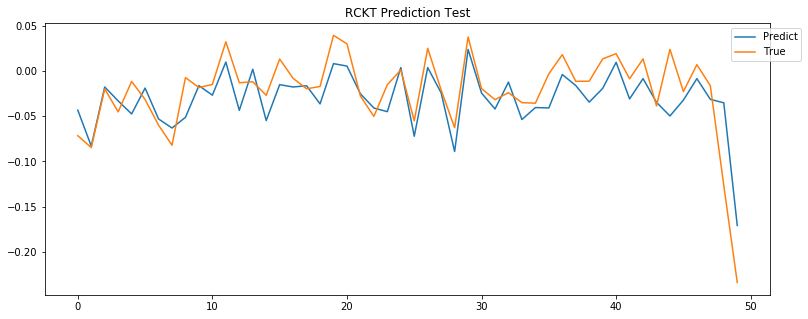

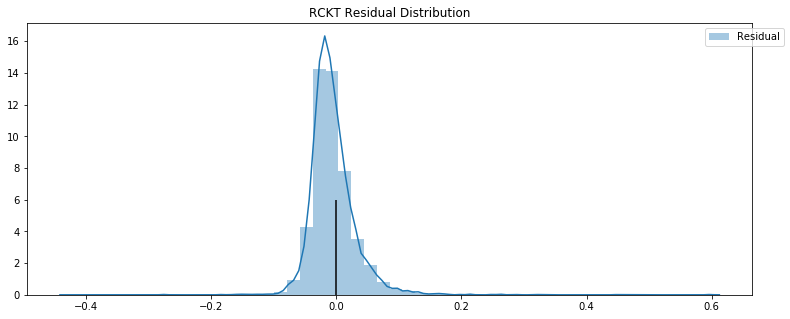

TBIO 0.2490615673854084 0.35520814695154235


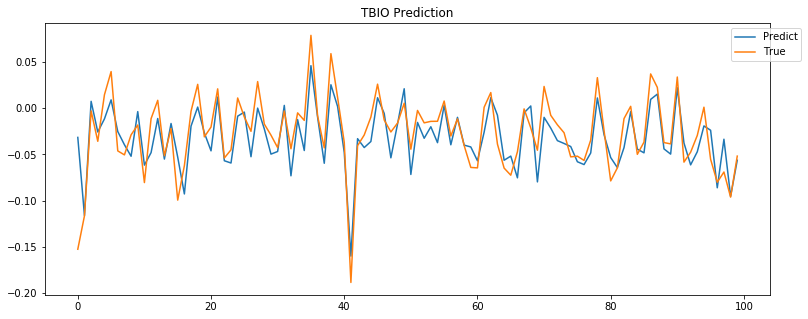

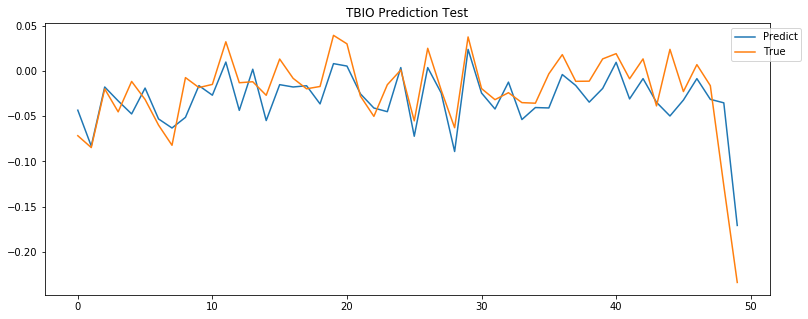

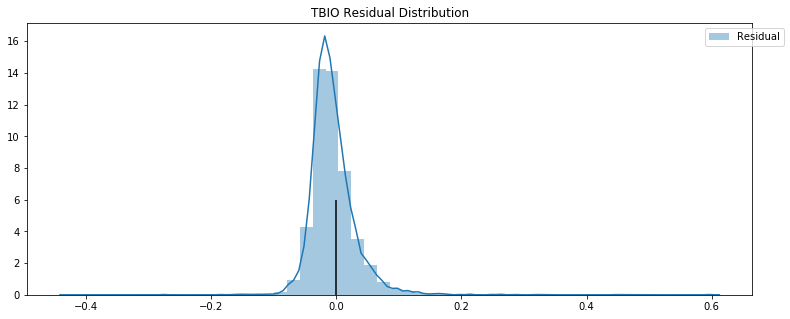

VYGR 0.24906203475026922 0.3552080907704297


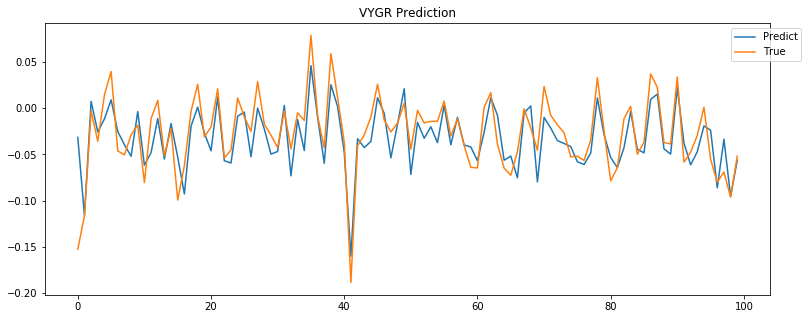

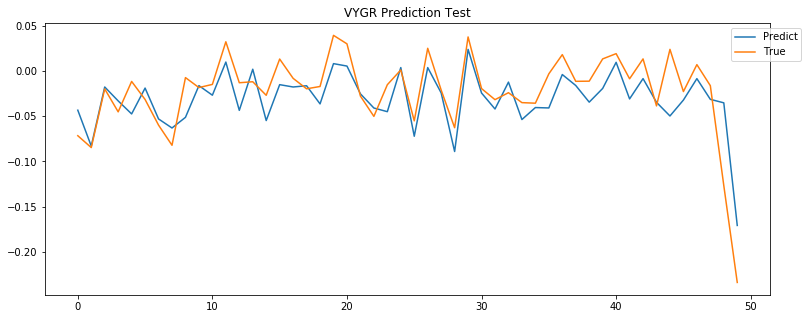

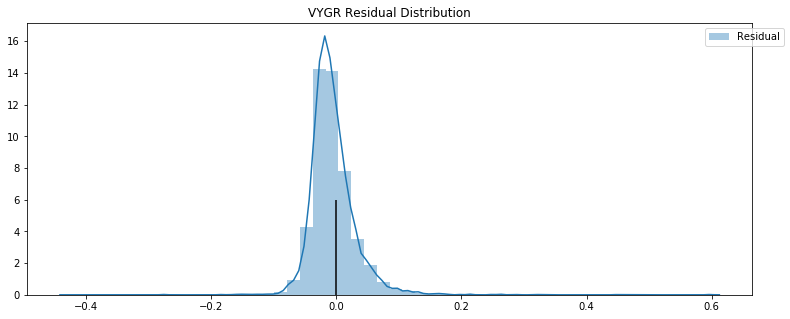

SGMO 0.2490624453020449 0.3552080789211848


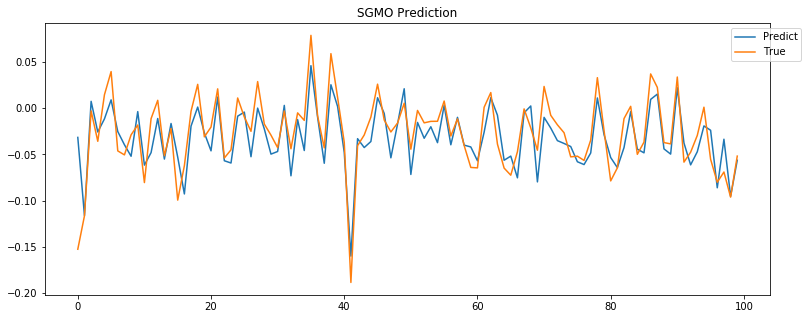

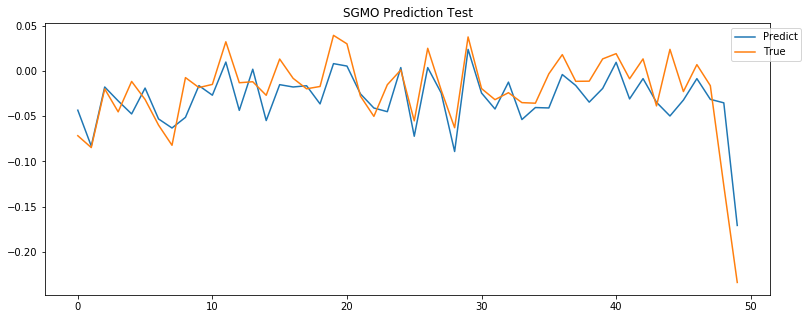

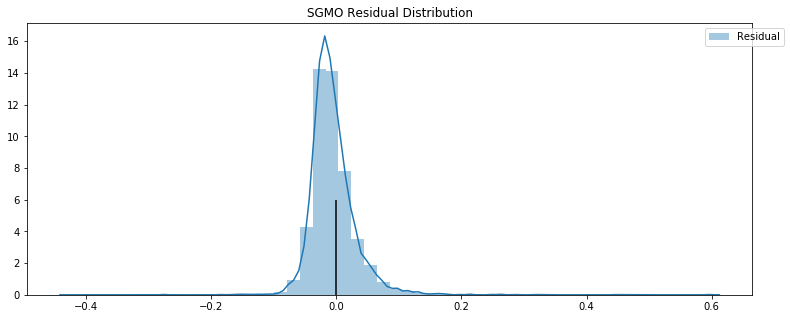

ODT 0.24906272870345647 0.3552080307901634


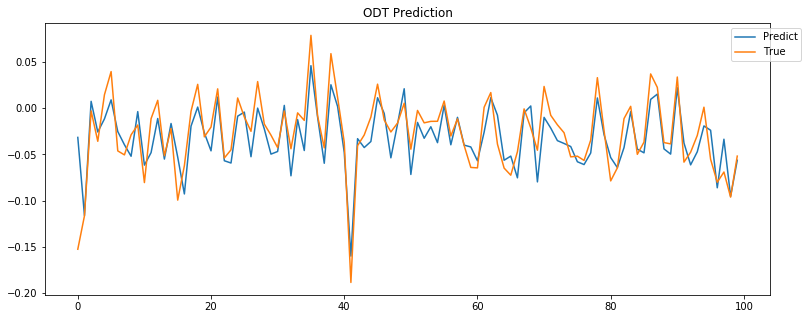

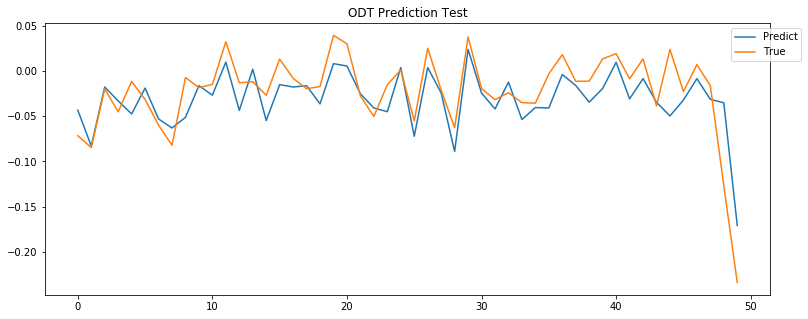

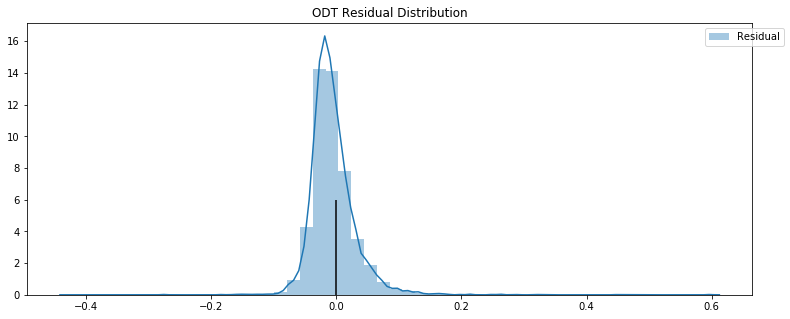

In [0]:
for stock in stocks:
  predict_train = model.predict(feature_train, batch_size = 25)
  predict_test = model.predict(feature_test, batch_size= 25)
  print(stock,r2_score(predict_test, label_test), r2_score(predict_train, label_train))
  plt.figure(figsize=(13,5))
  plt.title(f"{stock} Prediction")
  plt.plot(predict_train[-100:], label = 'Predict')
  plt.plot(label_train[-100:], label= 'True')
  plt.legend(bbox_to_anchor=(1.05, 1))
  plt.show()

  plt.figure(figsize=(13,5))
  plt.title(f"{stock} Prediction Test")
  plt.plot(predict_test[-100:], label = 'Predict')
  plt.plot(label_test[-100:], label= 'True')
  plt.legend(bbox_to_anchor=(1.05, 1))
  plt.show()
  plt.figure(figsize=(13,5))
  plt.title(f"{stock} Residual Distribution")
  sns.distplot(predict_train- label_train, label = 'Residual')
  plt.vlines(0,0,6)
  plt.legend(bbox_to_anchor=(1.05, 1))
  plt.show()

In [0]:
model.save_weights('gru_stateful_1_30_19.h5')